# Data Preprocessing

➡️ Loading Dataset and Removing null records...

🧾 Initial records after dropping nulls: 5000
➡️ Checking for valid images...
🔍 Scanning 5000 images...
🖼️ Processed 0/5000 images
🖼️ Processed 500/5000 images
🖼️ Processed 1000/5000 images


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🖼️ Processed 1500/5000 images
🖼️ Processed 2000/5000 images
🖼️ Processed 2500/5000 images
🖼️ Processed 3000/5000 images
🖼️ Processed 3500/5000 images
🖼️ Processed 4000/5000 images
🖼️ Processed 4500/5000 images
✔️ Total valid images: 4701 / 5000

➡️ Modifying Dataset with valid images...

✅ Records after filtering with valid images: 4701
📁 Total images found       : 5000
✅ Valid images             : 4701
❌ Invalid images (declined): 299


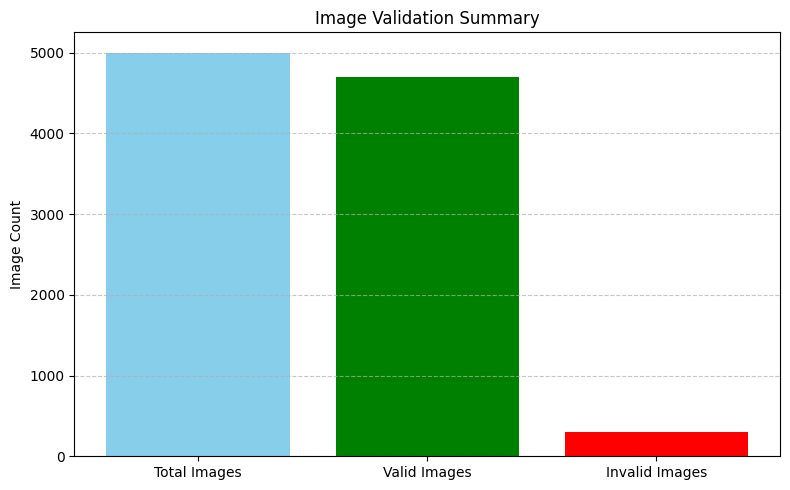

🔍 Smallest Image:
filename    img_559749.jpg
Width                  103
Height                 104
Area                 10712
Name: 3476, dtype: object

🔍 Largest Image:
filename    img_614322.jpg
Width                 5660
Height                4467
Area              25283220
Name: 1268, dtype: object


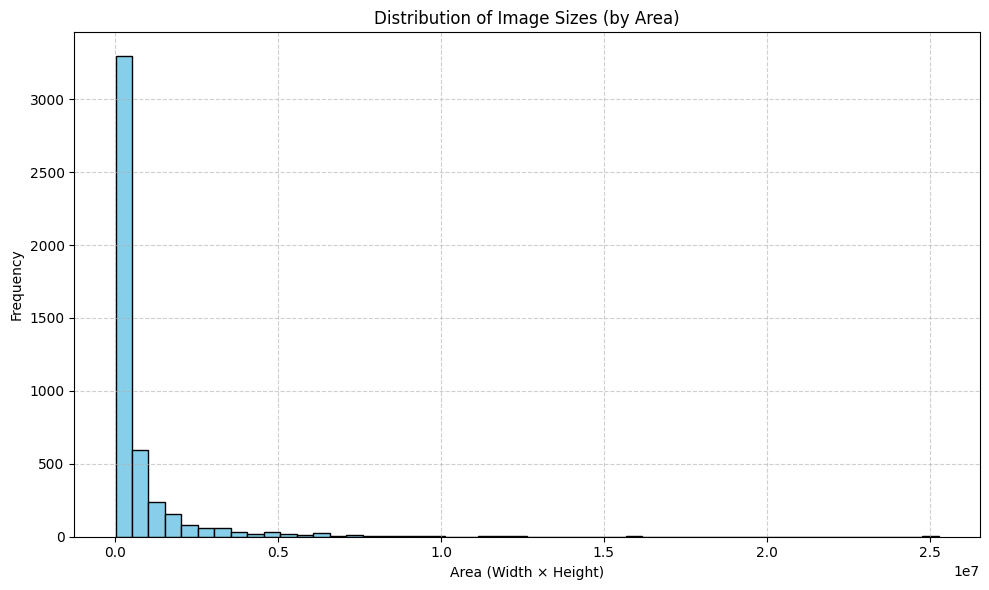

➡️ Generating Wordcloud before cleaning...


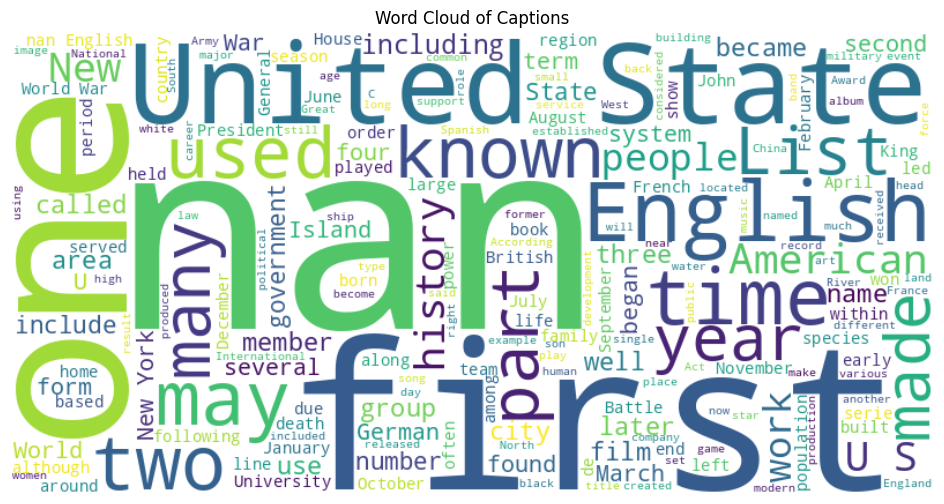

➡️ Cleaning captions (remove 'nan', 'list of' and special characters)...
🧹 Cleaned Captions Count: 4701


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


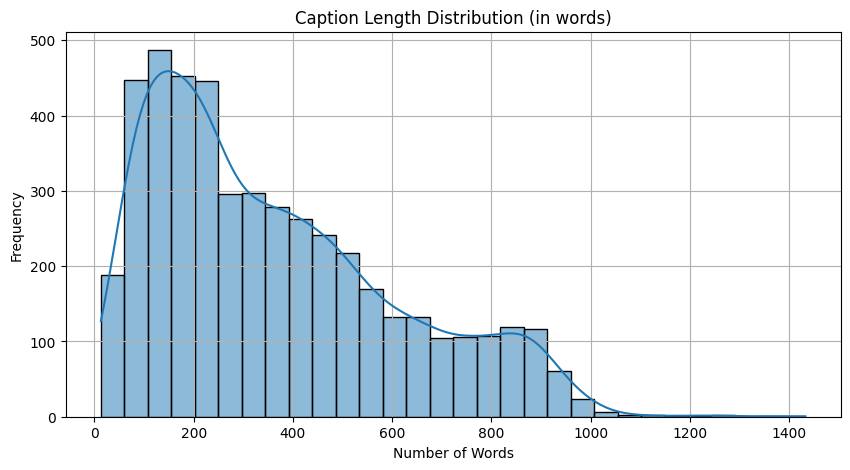

📏 Max Caption Length: 1433
📉 Min Caption Length: 13
📊 Average Caption Length: 361.56838970431824

➡️ Truncating Caption length to 100 words maximum...

🔁 After Truncation:
📏 Max Caption Length: 100
📉 Min Caption Length: 13
📊 Average Caption Length: 96.25909380982769
➡️ Generating Wordcloud after cleaning...


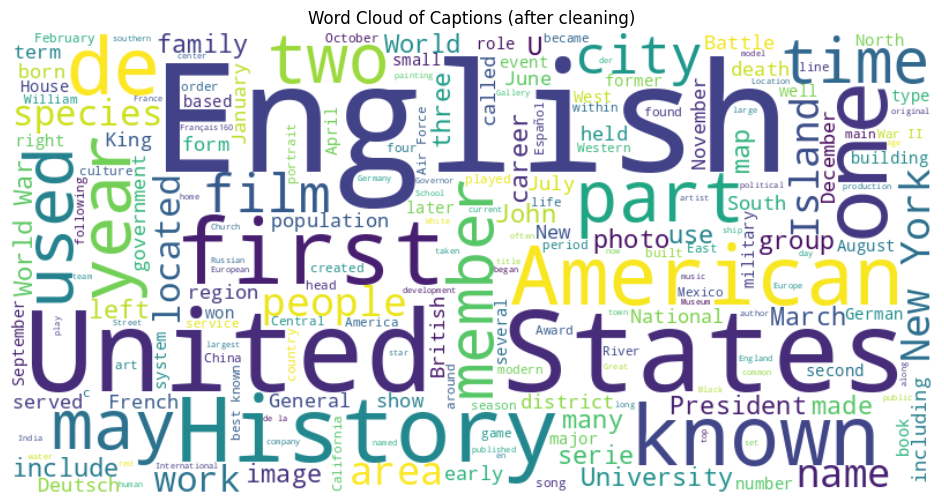

➡️ Splitting Data into Train, Validation and Test sets...

📊 Train set size: 4513
📊 Validation set size: 93
📊 Test set size: 95



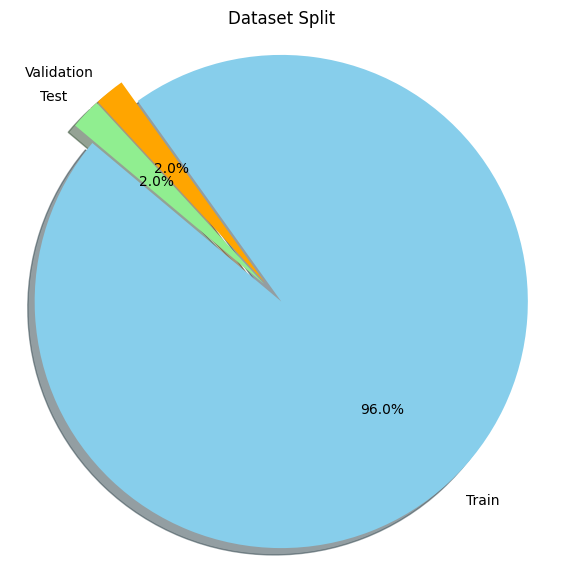

➡️ Resizing and saving images to 240x240 (with center crop)...
📁 Processing TRAIN set...
🖼️ train: Saved 500/4513 images...
🖼️ train: Saved 3000/4513 images...
🖼️ train: Saved 3500/4513 images...
🖼️ train: Saved 2500/4513 images...
🖼️ train: Saved 4500/4513 images...
🖼️ train: Saved 4000/4513 images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


🖼️ train: Saved 2000/4513 images...
🖼️ train: Saved 1500/4513 images...


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🖼️ train: Saved 0/4513 images...
🖼️ train: Saved 1000/4513 images...
📁 Processing VAL set...
📁 Processing TEST set...

✅ All resized images saved!

🖼️ Displaying 9 sample transformed images (from train)...


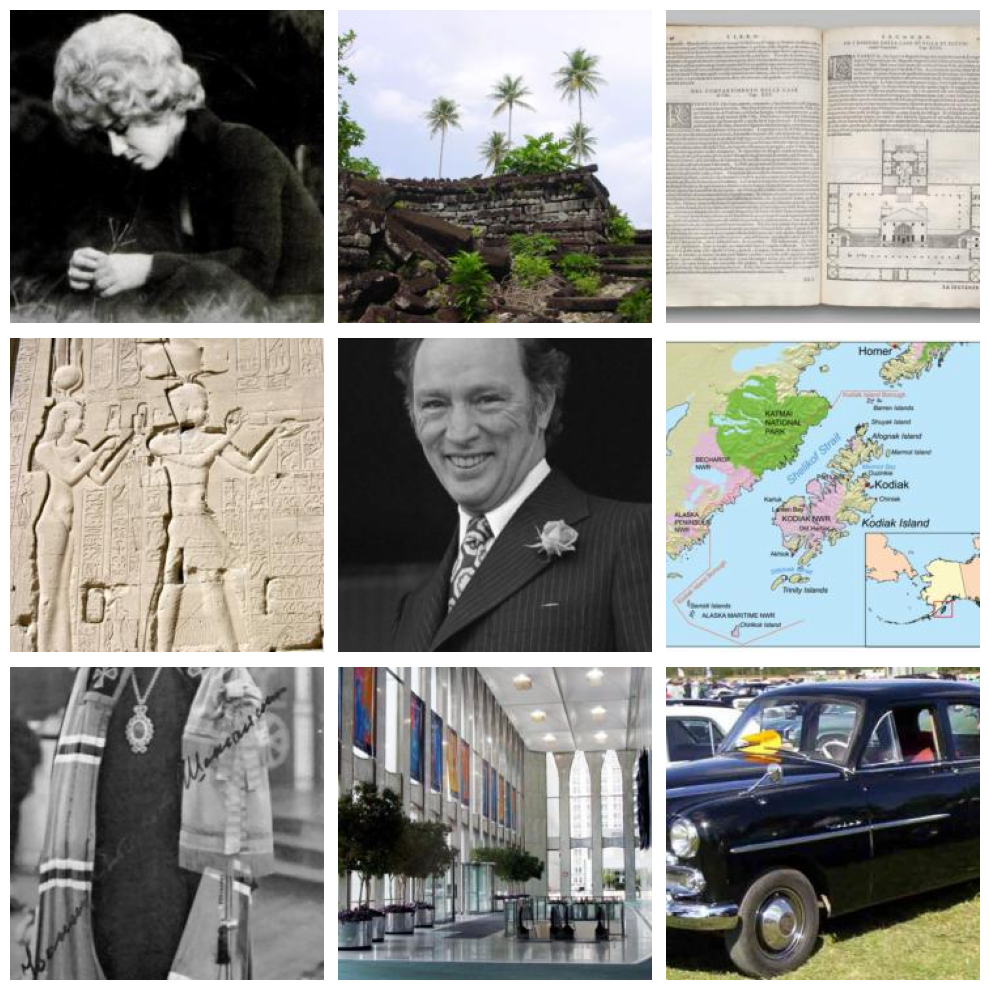

✅ Data Preprocessing Completed with Verbose Logs!

➡️ Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer and Dataset class loaded. Dataloaders ready!


In [1]:
import os
import re
import time
import nltk
import json
import torch
import random
import pickle
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoTokenizer
from torchvision import transforms, models
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split

# Set seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Paths
IMAGE_DIR = "/kaggle/input/wit-en-5k-dataset-by-pankaj/image_data"
TEXT_DATA_PATH = "/kaggle/input/wit-en-5k-dataset-by-pankaj/text_data.csv"
MODEL_SAVE_PATH = "/kaggle/working/multimodal_transformer_captioning.pth"

print("➡️ Loading Dataset and Removing null records...\n")
text_data = pd.read_csv(TEXT_DATA_PATH)
text_data = text_data.dropna()
print(f"🧾 Initial records after dropping nulls: {len(text_data)}")

# --- IMAGE PREPROCESSING ---
print("➡️ Checking for valid images...")
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except:
        return False

image_sizes = []
existing_images = []
total_images = len(os.listdir(IMAGE_DIR))
print(f"🔍 Scanning {total_images} images...")

for i, filename in enumerate(os.listdir(IMAGE_DIR)):
    file_path = os.path.join(IMAGE_DIR, filename)
    if os.path.isfile(file_path) and is_valid_image(file_path):
        existing_images.append(filename)
        with Image.open(file_path) as img:
            width, height = img.size
        image_sizes.append({'filename': filename, 'Width': width, 'Height': height})
    if i % 500 == 0:
        print(f"🖼️ Processed {i}/{total_images} images")

valid_img_cnt = len(existing_images)

print(f"✔️ Total valid images: {valid_img_cnt} / {total_images}\n")
print("➡️ Modifying Dataset with valid images...\n")
text_data = text_data[text_data['image_filename'].isin(existing_images)].reset_index(drop=True)
print(f"✅ Records after filtering with valid images: {len(text_data)}")

# Image stats
invalid_images = total_images - valid_img_cnt
print(f"📁 Total images found       : {total_images}")
print(f"✅ Valid images             : {valid_img_cnt}")
print(f"❌ Invalid images (declined): {invalid_images}")

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(["Total Images", "Valid Images", "Invalid Images"], [total_images, valid_img_cnt, invalid_images],
        color=["skyblue", "green", "red"])
plt.title("Image Validation Summary")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Image size distribution
image_sizes_df = pd.DataFrame(image_sizes)
image_sizes_df["Area"] = image_sizes_df["Width"] * image_sizes_df["Height"]

min_size = image_sizes_df.loc[image_sizes_df["Area"].idxmin()]
max_size = image_sizes_df.loc[image_sizes_df["Area"].idxmax()]

print("🔍 Smallest Image:")
print(min_size)
print("\n🔍 Largest Image:")
print(max_size)

plt.figure(figsize=(10, 6))
plt.hist(image_sizes_df["Area"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Image Sizes (by Area)")
plt.xlabel("Area (Width × Height)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- TEXT PREPROCESSING ---
print("➡️ Generating Wordcloud before cleaning...")
all_text = " ".join(text_data['text_data'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Captions")
plt.show()

print("➡️ Cleaning captions (remove 'nan', 'list of' and special characters)...")

def clean_nan_from_caption(caption):
    if isinstance(caption, float) and np.isnan(caption):
        return ""
    caption = str(caption)
    caption = caption.replace('nan', '').strip()
    caption = caption.replace('List of', '').strip()
    caption = caption.replace('list of', '').strip()
    return caption

def remove_special_characters(caption):
    caption = re.sub(r'[^\w\sáéíóúñüçãàè]', '', caption)
    return caption

def clean_caption(caption):
    caption = clean_nan_from_caption(caption)
    caption = remove_special_characters(caption)
    return caption

text_data['text_data'] = text_data['text_data'].apply(clean_caption)
print(f"🧹 Cleaned Captions Count: {len(text_data)}")

caption_lengths = text_data['text_data'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(caption_lengths, bins=30, kde=True)
plt.title("Caption Length Distribution (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("📏 Max Caption Length:", caption_lengths.max())
print("📉 Min Caption Length:", caption_lengths.min())
print("📊 Average Caption Length:", caption_lengths.mean())

print("\n➡️ Truncating Caption length to 100 words maximum...\n")
def truncate_caption(caption, max_words=100):
    words = caption.split()
    if len(words) > max_words:
        return " ".join(words[:max_words])
    return caption

text_data['text_data'] = text_data['text_data'].apply(lambda x: truncate_caption(x, max_words=100))
caption_lengths = text_data['text_data'].apply(lambda x: len(x.split()))
print("🔁 After Truncation:")
print("📏 Max Caption Length:", caption_lengths.max())
print("📉 Min Caption Length:", caption_lengths.min())
print("📊 Average Caption Length:", caption_lengths.mean())

print("➡️ Generating Wordcloud after cleaning...")
all_text = " ".join(text_data['text_data'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Captions (after cleaning)")
plt.show()

# --- DATA SPLITTING ---
print("➡️ Splitting Data into Train, Validation and Test sets...\n")
train_texts, test_texts, train_images, test_images = train_test_split(
    text_data['text_data'], text_data['image_filename'], test_size=0.02, random_state=42
)
train_texts, val_texts, train_images, val_images = train_test_split(
    train_texts, train_images, test_size=0.02, random_state=42
)

train_df = pd.DataFrame({'image_filename': train_images, 'text_data': train_texts})
val_df = pd.DataFrame({'image_filename': val_images, 'text_data': val_texts})
test_df = pd.DataFrame({'image_filename': test_images, 'text_data': test_texts})

print(f"📊 Train set size: {len(train_df)}")
print(f"📊 Validation set size: {len(val_df)}")
print(f"📊 Test set size: {len(test_df)}\n")

# Pie chart
labels = ['Train', 'Validation', 'Test']
sizes = [len(train_df), len(val_df), len(test_df)]
colors = ['skyblue', 'orange', 'lightgreen']
explode = (0.05, 0.05, 0.05)

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=explode, shadow=True)
plt.title('Dataset Split')
plt.axis('equal')
plt.show()

# --- TRANSFORMS & IMAGE SAVING ---
print("➡️ Resizing and saving images to 240x240 (with center crop)...")
RESIZED_IMAGE_DIR = "/kaggle/working/resized_images"

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

resize_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(240)
])

splits = {'train': train_df, 'val': val_df, 'test': test_df}
for split in splits.keys():
    os.makedirs(os.path.join(RESIZED_IMAGE_DIR, split), exist_ok=True)

for split_name, df in splits.items():
    print(f"📁 Processing {split_name.upper()} set...")
    for idx, row in df.iterrows():
        filename = row['image_filename']
        src_path = os.path.join(IMAGE_DIR, filename)
        dest_path = os.path.join(RESIZED_IMAGE_DIR, split_name, filename)

        try:
            image = Image.open(src_path).convert("RGB")
            image = resize_transform(image)
            image.save(dest_path)
            if idx % 500 == 0:
                print(f"🖼️ {split_name}: Saved {idx}/{len(df)} images...")
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

print("\n✅ All resized images saved!\n")

# --- SAMPLE IMAGE VISUALIZATION ---
print("🖼️ Displaying 9 sample transformed images (from train)...")

def show_images_only_from_dir(image_dir, num_images=9):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    indices = random.sample(range(len(image_files)), num_images)

    images = []
    for i in indices:
        img_path = os.path.join(image_dir, image_files[i])
        image = Image.open(img_path).convert('RGB')
        image = image_transform(image)
        images.append(image)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_only_from_dir(os.path.join(RESIZED_IMAGE_DIR, 'train'))

print("✅ Data Preprocessing Completed with Verbose Logs!\n")

# Tokenizer (BERT Base Uncased)
print("➡️ Loading BERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize captions
def tokenize_caption(caption, tokenizer, max_length=100):
    tokens = tokenizer(
        caption,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return tokens

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, transform=None, max_length=100):
        self.data = dataframe
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_filename'])

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        caption = row['text_data']
        tokenized = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze(0)      # shape: [max_length]
        attention_mask = tokenized['attention_mask'].squeeze(0)  # shape: [max_length]

        return {
            'image': image,                         # Tensor: [3, 240, 240]
            'input_ids': input_ids,                 # Tensor: [max_length]
            'attention_mask': attention_mask,       # Tensor: [max_length]
            'caption': caption                      # Original string (for evaluation)
        }

# Create Dataset instances
train_dataset = ImageCaptioningDataset(train_df, os.path.join(RESIZED_IMAGE_DIR, 'train'), tokenizer, transform=image_transform)
val_dataset   = ImageCaptioningDataset(val_df, os.path.join(RESIZED_IMAGE_DIR, 'val'), tokenizer, transform=image_transform)
test_dataset  = ImageCaptioningDataset(test_df, os.path.join(RESIZED_IMAGE_DIR, 'test'), tokenizer, transform=image_transform)

# Dataloaders
BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

print("✅ Tokenizer and Dataset class loaded. Dataloaders ready!")

## The minimum length caption with image

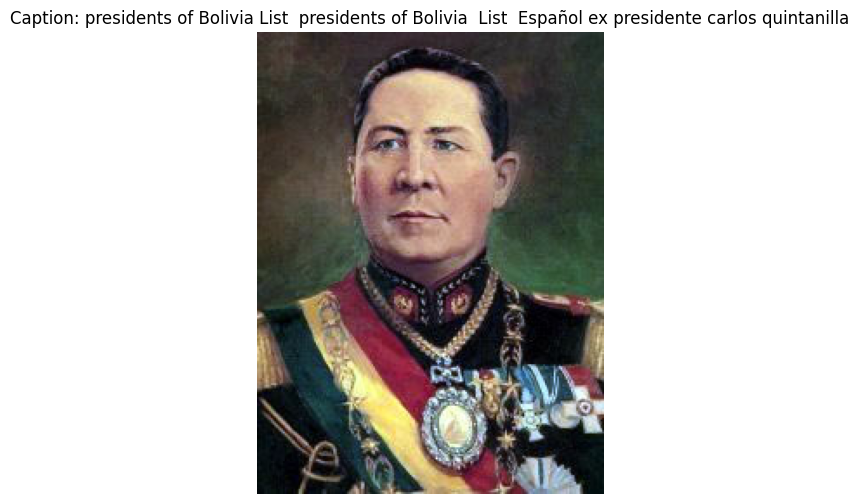

📉 Minimum Caption Length for:
Image: img_632273.jpg
Caption: presidents of Bolivia List  presidents of Bolivia  List  Español ex presidente carlos quintanilla


In [3]:
# Find the row with minimum caption length
min_caption_idx = caption_lengths.idxmin()
min_caption = text_data.iloc[min_caption_idx]
min_caption_text = min_caption['text_data']
min_caption_img_filename = min_caption['image_filename']
min_caption_img_path = os.path.join(IMAGE_DIR, min_caption_img_filename)

# Load and display the image with its caption
image = Image.open(min_caption_img_path).convert('RGB')

# Plot the image and display the caption
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(f"Caption: {min_caption_text}")
plt.show()

# Print the caption and the corresponding image filename
print("📉 Minimum Caption Length for:")
print(f"Image: {min_caption_img_filename}")
print(f"Caption: {min_caption_text}")

## Showing 3 random samples

🎯 Showing 3 random samples from test set with captions...



<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from current font.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  plt.tight_layout()
<ipython-input-4-2890abbdc8d0>:24: UserWarning: Glyph 2332 (\N{DEV

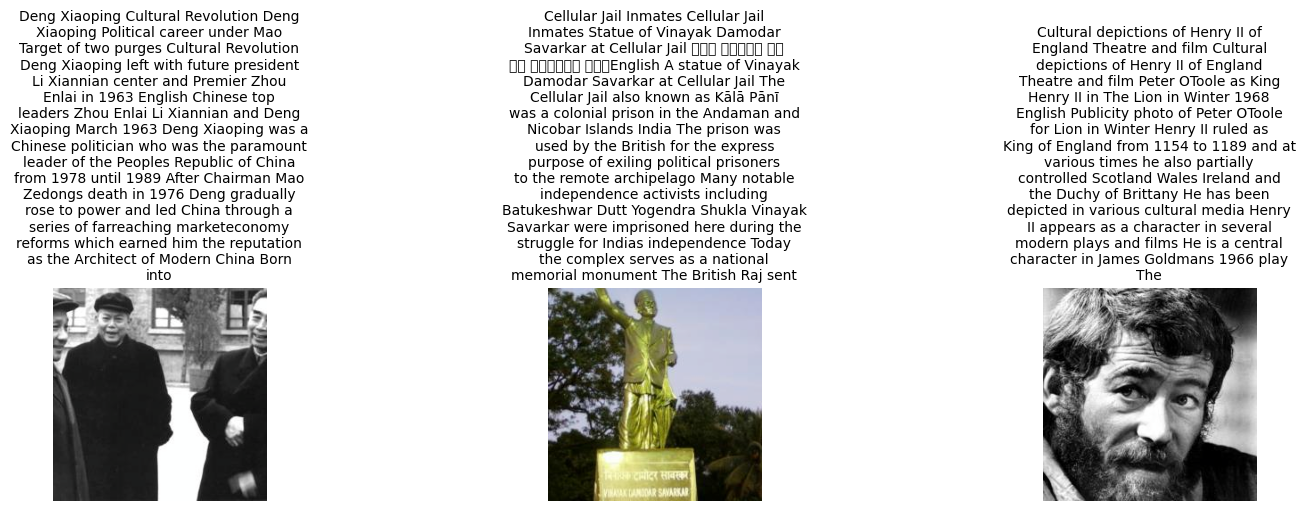

In [4]:
# --- SHOW RANDOM IMAGES AND CAPTIONS ---
print("🎯 Showing 3 random samples from test set with captions...\n")

def show_random_test_samples(dataset, num_samples=3):
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, sample in enumerate(samples):
        image = sample['image']
        caption = sample['caption']

        # Unnormalize image
        image = image.permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        wrapped_caption = "\n".join(textwrap.wrap(caption, width=40))
        plt.title(wrapped_caption, fontsize=10)

    plt.tight_layout()
    plt.show()

# Call the function with test dataset
show_random_test_samples(test_dataset)

# Model-1: Setup (CNN + LSTM) 

In [5]:
# Define Encoder (CNN using ResNet50)
class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super(CNNEncoder, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False
        modules = list(resnet.children())[:-1]  # remove FC layer
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.LayerNorm(embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

# Define Decoder (LSTM)
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(RNNDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])  # remove <end> token
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# Combine Encoder and Decoder
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

print("✅ Model setup complete (CNN + LSTM) !\n")

print("➡️ Defining training and evaluation essentials...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = tokenizer.vocab_size
embed_size = 256
hidden_size = 512
num_epochs = 5
learning_rate = 0.001

encoder = CNNEncoder(embed_size).to(device)
decoder = RNNDecoder(embed_size, hidden_size, vocab_size).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("➡️ Training loop starts...\n")
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(outputs, targets, ignore_index):
    predicted = torch.argmax(outputs, dim=-1)
    mask = (targets != ignore_index)
    correct = (predicted == targets) * mask
    total = mask.sum()
    correct_sum = correct.sum()
    accuracy = correct_sum.float() / total if total > 0 else torch.tensor(0.0).to(outputs.device)
    return accuracy.item()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    total_batches = 0
    for batch in train_loader:
        images = batch['image'].to(device)
        captions = batch['input_ids'].to(device)

        optimizer.zero_grad()
        outputs = model(images, captions)
        targets = captions[:, 1:]
        outputs = outputs[:, :-1, :]

        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        accuracy = calculate_accuracy(outputs, targets, tokenizer.pad_token_id)
        running_accuracy += accuracy
        total_batches += 1

    avg_loss = running_loss / len(train_loader)
    avg_accuracy = running_accuracy / total_batches
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    total_val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            captions = batch['input_ids'].to(device)

            outputs = model(images, captions)
            targets = captions[:, 1:]
            outputs = outputs[:, :-1, :]

            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()

            accuracy = calculate_accuracy(outputs, targets, tokenizer.pad_token_id)
            val_accuracy += accuracy
            total_val_batches += 1

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / total_val_batches
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}\n")

✅ Model setup complete (CNN + LSTM) !

➡️ Defining training and evaluation essentials...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s] 


➡️ Training loop starts...

Epoch 1/5, Train Loss: 7.9071, Train Accuracy: 0.0696
Validation Loss: 7.6744, Validation Accuracy: 0.0745

Epoch 2/5, Train Loss: 6.9687, Train Accuracy: 0.0925
Validation Loss: 7.5456, Validation Accuracy: 0.0834

Epoch 3/5, Train Loss: 5.8889, Train Accuracy: 0.1248
Validation Loss: 7.6383, Validation Accuracy: 0.0874

Epoch 4/5, Train Loss: 4.8088, Train Accuracy: 0.2030
Validation Loss: 7.8497, Validation Accuracy: 0.0874

Epoch 5/5, Train Loss: 3.9298, Train Accuracy: 0.3017
Validation Loss: 8.1081, Validation Accuracy: 0.0817



## Accuracy and Loss Plot

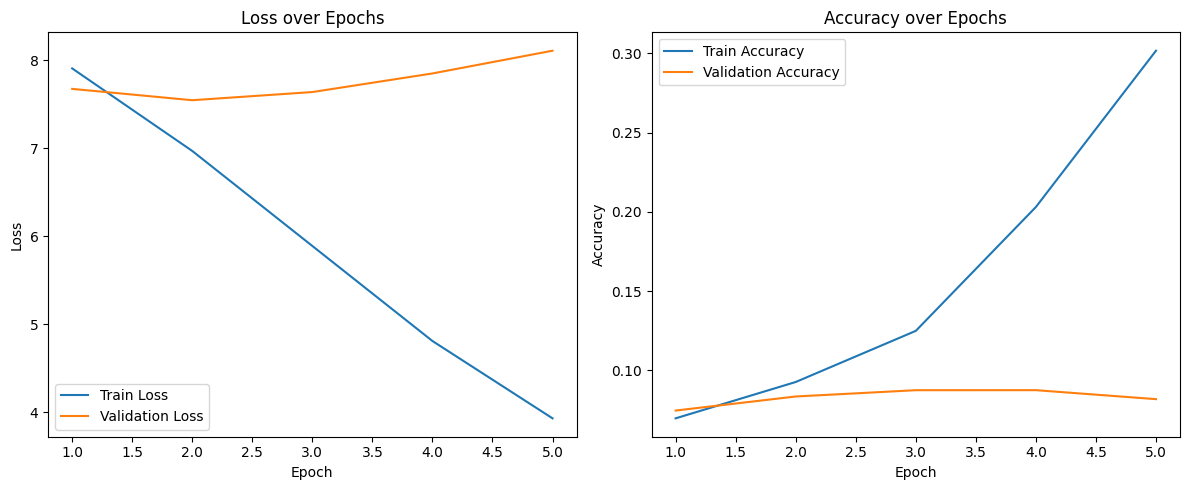

In [6]:
# Plotting Loss and Accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# saving model-1 result in result history
history_model1 = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accuracies,
    "val_acc": val_accuracies
}

with open("model1_history.pkl", "wb") as f:
    pickle.dump(history_model1, f)

## Caption Generation & BLEU Score


🧪 Generating captions for 3 test images...

🔹 Test Image 1:
   🔷Real Caption: Stevenson screen Stevenson screen Exterior of a Stevenson screen A
Stevenson screen or instrument shelter is a shelter or an enclosure to
meteorological instruments against precipitation and direct heat
radiation from outside sources while still allowing air to circulate
freely around them It forms part of a standard weather station and
holds instruments that may include thermometers a hygrometer a
psychrometer a dewcell a barometer and a thermograph Stevenson screens
may also be known as a cotton region shelter an instrument shelter a
thermometer shelter a thermoscreen or a thermometer screen Its purpose
is to provide a standardised environment in
   🔶Generated Caption: the in of united united december air campus in the united states
births of jeffrey english english photo of the



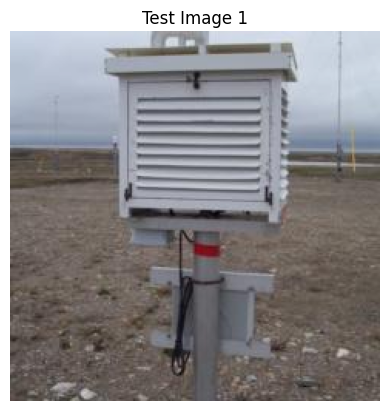

🔹 Test Image 2:
   🔷Real Caption: Gymnammodytes cicerelus Gymnammodytes cicerelus Picture of
Gymnammodytes cicerelus Gymnammodytes cicerelus also known as
Mediterranean sand eel sonso in Catalan and barrinaire or enfú in
Menorca is a fish in the family Ammodytidae It is the only species of
this family in the Mediterranean Sea It is a species from the family
Ammodytidae the sandlances or sandeels It is found over sandy or
gravelly substrates in the eastcentral Atlantic from Portugal to
Senegal including the Canary Islands and the Cape Verde Islands and
into the Mediterranean Sea and eastwards into the Black Sea Its
maximum size is 17 cm It is
   🔶Generated Caption: the of of of and and of of of and and of of and and of of greece and
of



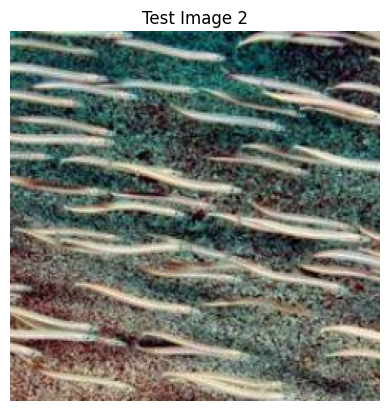

🔹 Test Image 3:
   🔷Real Caption: Aztec codices Aztec codices History of Tlaxcala Hernán Cortés and
Malinche meet Moctezuma II Tenochtitlan Entrance of Her Cortes
November 8 1519 From the Lienzo de Tlaxcala created by the Tlaxcalans
to remind the Spanish of their loyalty to Castile and the importance
of Tlaxcala during the Conquest The text mixes styles and includes
anachronisms such as the Europeanstyle chairs in this image Original
ca 1550 AD This facsimile published c 1890 Español Tenochtitlan Tierra
del nopal Entrada de Her Cortes la cual se verifico el 8 de Noviembre
de 1519 English Tenochtitlan Entrance of Her Cortes Cortez and La
   🔶Generated Caption: history of the early states century europe early of century america
early century century early kingdom century century early early



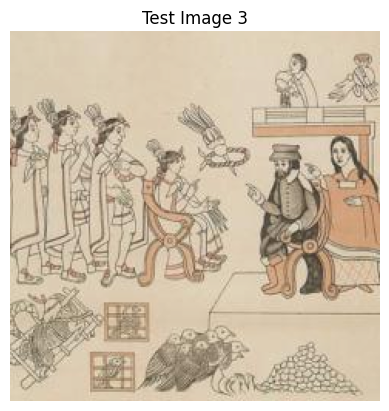


🎯 BLEU Score (for 3 images): 0.0127


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [7]:
def generate_caption(model, image_tensor, tokenizer, max_length=20):
    model.eval()
    with torch.no_grad():
        feature = model.encoder(image_tensor.unsqueeze(0).to(device))
        caption = [tokenizer.cls_token_id]
        for _ in range(max_length):
            input_ids = torch.tensor(caption).unsqueeze(0).to(device)
            outputs = model.decoder(feature, input_ids)
            next_token_logits = outputs[0, -1, :]
            next_token = torch.argmax(next_token_logits).item()
            caption.append(next_token)
            if next_token == tokenizer.sep_token_id:
                break
        return tokenizer.decode(caption, skip_special_tokens=True)

# Evaluate on test set
references = []
hypotheses = []
num_examples_to_show = 3

print(f"\n🧪 Generating captions for {num_examples_to_show} test images...\n")

for idx, batch in enumerate(test_loader):
    image = batch['image'][0]
    real_caption = batch['caption'][0]
    generated_caption = generate_caption(model, image, tokenizer)

    references.append([real_caption.split()])
    hypotheses.append(generated_caption.split())

    print(f"🔹 Test Image {idx+1}:")
    print(f"   🔷Real Caption: {textwrap.fill(real_caption, 70)}")
    print(f"   🔶Generated Caption: {textwrap.fill(generated_caption, 70)}\n")
    plt.figure()
    plt.imshow(image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.axis('off')
    plt.title(f"Test Image {idx+1}")
    plt.show()

    if idx == num_examples_to_show - 1:
        break

bleu_score = corpus_bleu(references, hypotheses)
print(f"\n🎯 BLEU Score (for {num_examples_to_show} images): {bleu_score:.4f}")

# Saving model-1 BELU Score
bleu_dict = {"Model-1": bleu_score}
with open("model1_bleu.json", "w") as f:
    json.dump(bleu_dict, f)

## Printing model architecture and Saving the model

In [8]:
# --- MODEL ARCHITECTURE PRINTING AND SAVING ---
print("\n➡️ Printing Model Architecture Details...")

def count_parameters(model):
    """Count the total number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model architecture details
print("\n📊 MODEL ARCHITECTURE:")
print("=" * 50)
print(model)
print("=" * 50)

# Count parameters by component
encoder_params = count_parameters(model.encoder) if hasattr(model, 'encoder') else 0
decoder_params = count_parameters(model.decoder) if hasattr(model, 'decoder') else 0
total_params = count_parameters(model)

print(f"\n🔢 PARAMETER COUNTS:")
print(f"   - Encoder: {encoder_params:,} parameters")
print(f"   - Decoder: {decoder_params:,} parameters")
print(f"   - Total: {total_params:,} trainable parameters")

# Print hyperparameters
print("\n⚙️ MODEL HYPERPARAMETERS:")
print(f"   - Embedding Size: {embed_size}")
print(f"   - Hidden Size: {hidden_size}")
print(f"   - Vocabulary Size: {vocab_size}")
print(f"   - Learning Rate: {learning_rate}")
print(f"   - Number of Epochs: {num_epochs}")
print(f"   - Device: {device}")

# Visualize encoder architecture
if hasattr(model, 'encoder') and hasattr(model.encoder, 'resnet'):
    print("\n🔍 ENCODER ARCHITECTURE (RESNET BACKBONE):")
    for name, module in model.encoder.resnet.named_children():
        print(f"   - {name}: {module.__class__.__name__}")

# --- MODEL SAVING ---
print("\n➡️ Saving the trained model...")

# Create model directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the full model
MODEL_PATH = "models/image_captioning_model_full.pth"
torch.save(model, MODEL_PATH)
print(f"✅ Full model saved to {MODEL_PATH}")

# Save model state dictionary
MODEL_STATE_DICT_PATH = "models/image_captioning_model_state_dict.pth"
torch.save({
    'encoder_state_dict': model.encoder.state_dict(),
    'decoder_state_dict': model.decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'vocab_size': vocab_size,
    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'epoch': num_epochs
}, MODEL_STATE_DICT_PATH)
print(f"✅ Model state dictionary saved to {MODEL_STATE_DICT_PATH}")


➡️ Printing Model Architecture Details...

📊 MODEL ARCHITECTURE:
ImageCaptioningModel(
  (encoder): CNNEncoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

# Model-2: Setup (CNN + GRU)

In [9]:
# Define Encoder (CNN using ResNet50) - Same as before
class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super(CNNEncoder, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.LayerNorm(embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

# Define Decoder (GRU)
class GRUDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(GRUDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])  # Remove <end> token
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.gru(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# Combine Encoder and Decoder
class ImageCaptioningModelGRU(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModelGRU, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

print("✅ Model setup complete (CNN + GRU) !\n")

print("➡️ Defining training and evaluation essentials...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = tokenizer.vocab_size
embed_size = 256
hidden_size = 512
num_epochs = 5
learning_rate = 0.001

encoder_gru = CNNEncoder(embed_size).to(device)
decoder_gru = GRUDecoder(embed_size, hidden_size, vocab_size).to(device)
model_gru = ImageCaptioningModelGRU(encoder_gru, decoder_gru).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

train_losses_gru = []
val_losses_gru = []
train_accuracies_gru = []
val_accuracies_gru = []

def calculate_accuracy(outputs, targets, ignore_index):
    predicted = torch.argmax(outputs, dim=-1)
    mask = (targets != ignore_index)
    correct = (predicted == targets) * mask
    total = mask.sum()
    correct_sum = correct.sum()
    accuracy = correct_sum.float() / total if total > 0 else torch.tensor(0.0).to(outputs.device)
    return accuracy.item()

print("➡️ Training loop starts for CNN + GRU...")
for epoch in range(num_epochs):
    model_gru.train()
    running_loss = 0.0
    running_accuracy = 0.0
    total_batches = 0
    for batch in train_loader:
        images = batch['image'].to(device)
        captions = batch['input_ids'].to(device)

        optimizer_gru.zero_grad()
        outputs = model_gru(images, captions)
        targets = captions[:, 1:]
        outputs = outputs[:, :-1, :]

        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer_gru.step()

        running_loss += loss.item()
        accuracy = calculate_accuracy(outputs, targets, tokenizer.pad_token_id)
        running_accuracy += accuracy
        total_batches += 1

    avg_loss = running_loss / len(train_loader)
    avg_accuracy = running_accuracy / total_batches
    train_losses_gru.append(avg_loss)
    train_accuracies_gru.append(avg_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f} (GRU)")

    # Validation
    model_gru.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    total_val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            captions = batch['input_ids'].to(device)

            outputs = model_gru(images, captions)
            targets = captions[:, 1:]
            outputs = outputs[:, :-1, :]

            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()
            accuracy = calculate_accuracy(outputs, targets, tokenizer.pad_token_id)
            val_accuracy += accuracy
            total_val_batches += 1

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / total_val_batches
    val_losses_gru.append(avg_val_loss)
    val_accuracies_gru.append(avg_val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f} (GRU)\n")

✅ Model setup complete (CNN + GRU) !

➡️ Defining training and evaluation essentials...
➡️ Training loop starts for CNN + GRU...
Epoch 1/5, Train Loss: 7.8258, Train Accuracy: 0.0746 (GRU)
Validation Loss: 7.5812, Validation Accuracy: 0.0803 (GRU)

Epoch 2/5, Train Loss: 6.5778, Train Accuracy: 0.1025 (GRU)
Validation Loss: 7.4847, Validation Accuracy: 0.0883 (GRU)

Epoch 3/5, Train Loss: 5.2512, Train Accuracy: 0.1534 (GRU)
Validation Loss: 7.6534, Validation Accuracy: 0.0899 (GRU)

Epoch 4/5, Train Loss: 4.0713, Train Accuracy: 0.2666 (GRU)
Validation Loss: 7.9487, Validation Accuracy: 0.0853 (GRU)

Epoch 5/5, Train Loss: 3.2700, Train Accuracy: 0.3681 (GRU)
Validation Loss: 8.2832, Validation Accuracy: 0.0838 (GRU)



## Accuracy and Loss Plotting

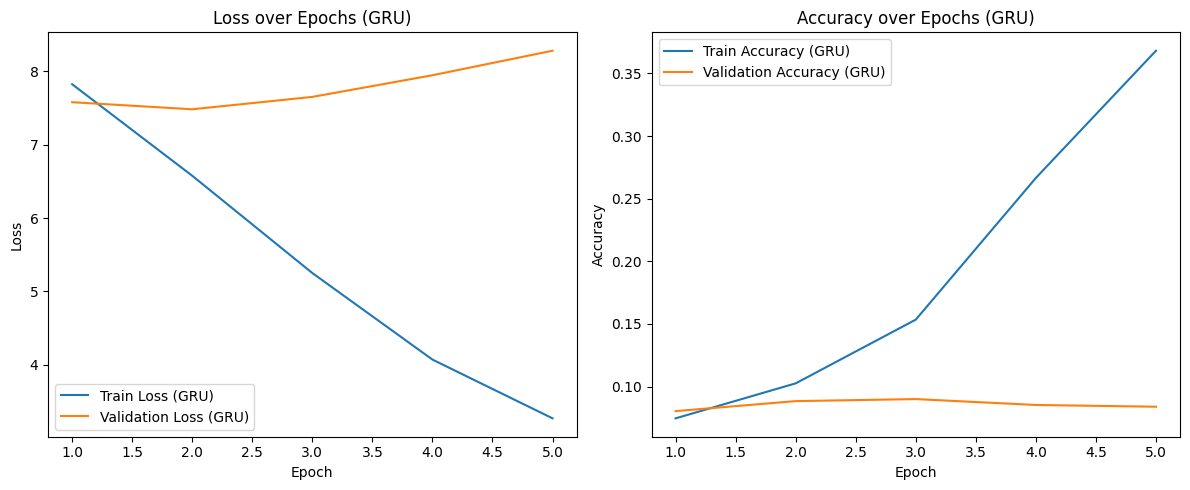

In [10]:
# Plotting Loss and Accuracy for GRU model
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_gru, label='Train Loss (GRU)')
plt.plot(epochs, val_losses_gru, label='Validation Loss (GRU)')
plt.title('Loss over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_gru, label='Train Accuracy (GRU)')
plt.plot(epochs, val_accuracies_gru, label='Validation Accuracy (GRU)')
plt.title('Accuracy over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# saving model-2 result in result history
history_model2 = {
    "train_loss": train_losses_gru,
    "val_loss": val_losses_gru,
    "train_acc": train_accuracies_gru,
    "val_acc": val_accuracies_gru
}

with open("model2_history.pkl", "wb") as f:
    pickle.dump(history_model2, f)

## Caption Generation & BLEU Score print


🧪 Generating captions for 3 test images (GRU)...

🔹 Test Image 1 (GRU):
   🔷Real Caption: Stevenson screen Stevenson screen Exterior of a Stevenson screen A
Stevenson screen or instrument shelter is a shelter or an enclosure to
meteorological instruments against precipitation and direct heat
radiation from outside sources while still allowing air to circulate
freely around them It forms part of a standard weather station and
holds instruments that may include thermometers a hygrometer a
psychrometer a dewcell a barometer and a thermograph Stevenson screens
may also be known as a cotton region shelter an instrument shelter a
thermometer shelter a thermoscreen or a thermometer screen Its purpose
is to provide a standardised environment in
   🔶Generated Caption: fort of australia fort australia australia fort fort australia
australia fort fort australia australia fort fort australia australia
fort fort



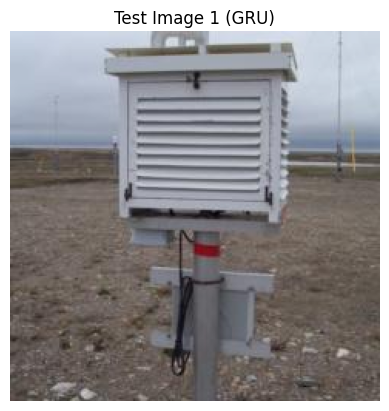

🔹 Test Image 2 (GRU):
   🔷Real Caption: Gymnammodytes cicerelus Gymnammodytes cicerelus Picture of
Gymnammodytes cicerelus Gymnammodytes cicerelus also known as
Mediterranean sand eel sonso in Catalan and barrinaire or enfú in
Menorca is a fish in the family Ammodytidae It is the only species of
this family in the Mediterranean Sea It is a species from the family
Ammodytidae the sandlances or sandeels It is found over sandy or
gravelly substrates in the eastcentral Atlantic from Portugal to
Senegal including the Canary Islands and the Cape Verde Islands and
into the Mediterranean Sea and eastwards into the Black Sea Its
maximum size is 17 cm It is
   🔶Generated Caption: marines marine marine marine marine marine marine marine marine marine
marine marine marine marine marine marine marine marine marine



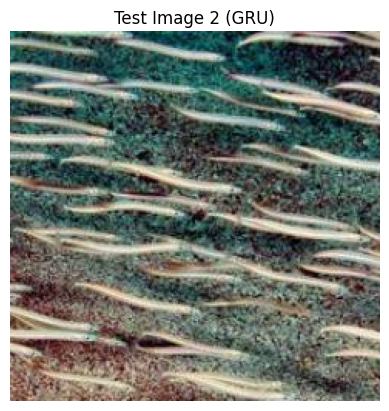

🔹 Test Image 3 (GRU):
   🔷Real Caption: Aztec codices Aztec codices History of Tlaxcala Hernán Cortés and
Malinche meet Moctezuma II Tenochtitlan Entrance of Her Cortes
November 8 1519 From the Lienzo de Tlaxcala created by the Tlaxcalans
to remind the Spanish of their loyalty to Castile and the importance
of Tlaxcala during the Conquest The text mixes styles and includes
anachronisms such as the Europeanstyle chairs in this image Original
ca 1550 AD This facsimile published c 1890 Español Tenochtitlan Tierra
del nopal Entrada de Her Cortes la cual se verifico el 8 de Noviembre
de 1519 English Tenochtitlan Entrance of Her Cortes Cortez and La
   🔶Generated Caption: anglo ofxonismism legend ofismism legendismism legendismism
legendismism legendism



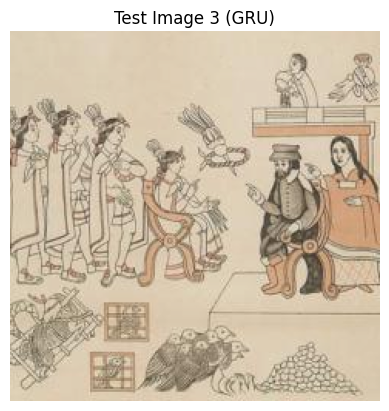


🎯 BLEU Score (for 3 images with GRU): 0.0018


In [11]:
def generate_caption_gru(model, image_tensor, tokenizer, max_length=20):
    model.eval()
    with torch.no_grad():
        feature = model.encoder(image_tensor.unsqueeze(0).to(device))
        caption = [tokenizer.cls_token_id]
        for _ in range(max_length):
            input_ids = torch.tensor(caption).unsqueeze(0).to(device)
            outputs = model.decoder(feature, input_ids)
            next_token_logits = outputs[0, -1, :]
            next_token = torch.argmax(next_token_logits).item()
            caption.append(next_token)
            if next_token == tokenizer.sep_token_id:
                break
        return tokenizer.decode(caption, skip_special_tokens=True)

# Evaluate on test set with GRU model
references_gru = []
hypotheses_gru = []
num_examples_to_show = 3

print(f"\n🧪 Generating captions for {num_examples_to_show} test images (GRU)...\n")

for idx, batch in enumerate(test_loader):
    image = batch['image'][0]
    real_caption = batch['caption'][0]
    generated_caption = generate_caption_gru(model_gru, image, tokenizer)

    references_gru.append([real_caption.split()])
    hypotheses_gru.append(generated_caption.split())

    print(f"🔹 Test Image {idx+1} (GRU):")
    print(f"   🔷Real Caption: {textwrap.fill(real_caption, 70)}")
    print(f"   🔶Generated Caption: {textwrap.fill(generated_caption, 70)}\n")
    plt.figure()
    plt.imshow(image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.axis('off')
    plt.title(f"Test Image {idx+1} (GRU)")
    plt.show()
    if idx == num_examples_to_show - 1:
        break

bleu_score_gru = corpus_bleu(references_gru, hypotheses_gru)
print(f"\n🎯 BLEU Score (for {num_examples_to_show} images with GRU): {bleu_score_gru:.4f}")

# Saving model-2 BELU Score
bleu_dict = {"Model-2": bleu_score_gru}
with open("model2_bleu.json", "w") as f:
    json.dump(bleu_dict, f)

## Printing model architecture and Saving the model

In [12]:
# 🔎 Print Model Architecture
print("\n📌 Model Architecture (CNN + GRU):\n")
print(model_gru)

# 💾 Save the Trained Model
save_path = "model2_cnn_gru.pth"
torch.save(model_gru.state_dict(), save_path)
print(f"\n✅ Model saved successfully at: {save_path}")


📌 Model Architecture (CNN + GRU):

ImageCaptioningModelGRU(
  (encoder): CNNEncoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

# Model-3: Setup (CNN + LSTM + Attention)

In [13]:
# === Encoder CNN ===
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.enc_image_size = encoded_image_size
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        for param in self.resnet.parameters():
            param.requires_grad = False

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        return features

# === Attention Mechanism ===
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = torch.tanh(att1 + att2.unsqueeze(1))
        e = self.full_att(att).squeeze(2)
        alpha = torch.softmax(e, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

# === Decoder with Attention ===
class DecoderWithAttention(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, attention_dim=256, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)

    def init_hidden_state(self, encoder_out):
        mean_enc = encoder_out.mean(dim=1)
        h = self.init_h(mean_enc)
        c = self.init_c(mean_enc)
        return h, c

    def forward(self, encoder_out, captions, lengths):
        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(encoder_out)

        batch_size = encoder_out.size(0)
        max_len = max(lengths) - 1
        predictions = torch.zeros(batch_size, max_len, self.vocab_size).to(captions.device)

        for t in range(max_len):
            batch_size_t = sum([l > t for l in lengths])
            context, _ = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            lstm_input = torch.cat([embeddings[:batch_size_t, t, :], context], dim=1)
            h, c = self.decode_step(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds

        return predictions

## Training, Accuracy and Loss plotting

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



📚 Epoch 1/5


TRAIN Loss: 8.0636 | Accuracy: 0.0728


VAL Loss: 7.7560 | Accuracy: 0.0835

📚 Epoch 2/5


TRAIN Loss: 7.4934 | Accuracy: 0.0943


VAL Loss: 7.5716 | Accuracy: 0.0953

📚 Epoch 3/5


TRAIN Loss: 7.1685 | Accuracy: 0.1048


VAL Loss: 7.4674 | Accuracy: 0.1067

📚 Epoch 4/5


TRAIN Loss: 6.8595 | Accuracy: 0.1152


VAL Loss: 7.4200 | Accuracy: 0.1175

📚 Epoch 5/5


TRAIN Loss: 6.5494 | Accuracy: 0.1259


VAL Loss: 7.3915 | Accuracy: 0.1200


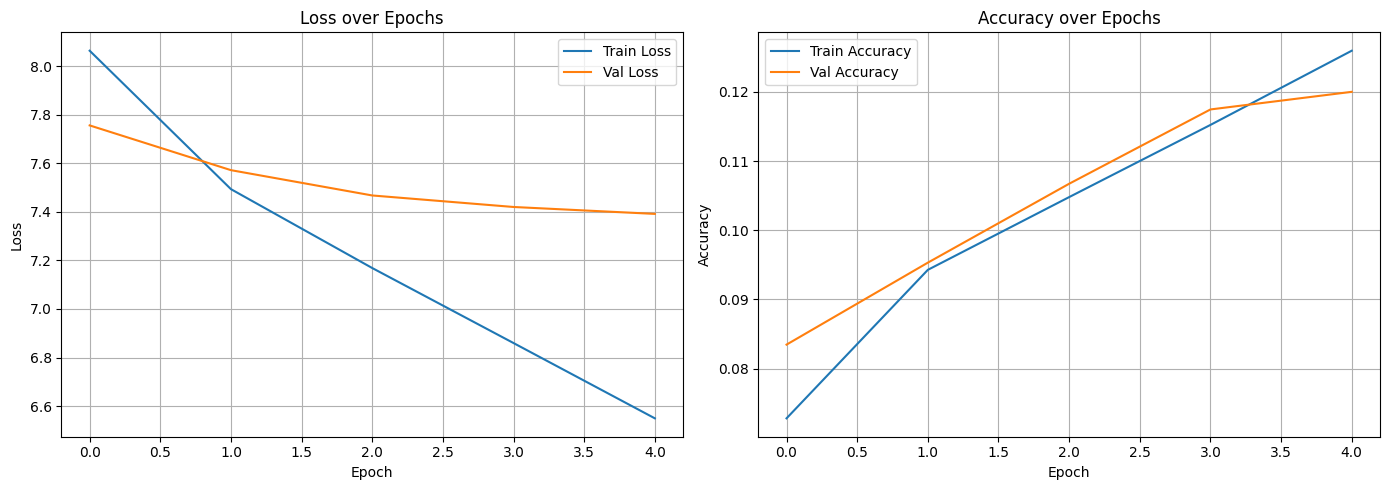

In [14]:
from torch.nn.utils.rnn import pack_padded_sequence

def train_model(encoder, decoder, dataloaders, criterion, optimizer, num_epochs=5):
    train_loader, val_loader = dataloaders
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\n📚 Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            encoder.train() if phase == 'train' else encoder.eval()
            decoder.train() if phase == 'train' else decoder.eval()
            loader = train_loader if phase == 'train' else val_loader

            running_loss, running_corrects, total_words = 0.0, 0, 0
            progress_bar = tqdm(loader, desc=f"{phase.capitalize()} Epoch {epoch+1}", leave=False)

            for batch in progress_bar:
                images = batch['image'].to(device)
                captions = batch['input_ids'].to(device)
                lengths = [torch.count_nonzero(cap != tokenizer.pad_token_id).item() for cap in captions]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    encoder_out = encoder(images)
                    outputs = decoder(encoder_out, captions[:, :-1], lengths)
                    targets = captions[:, 1:]

                    # Pack sequences for loss
                    packed_outputs = pack_padded_sequence(outputs, [l - 1 for l in lengths], batch_first=True, enforce_sorted=False)
                    packed_targets = pack_padded_sequence(targets, [l - 1 for l in lengths], batch_first=True, enforce_sorted=False)

                    loss = criterion(packed_outputs.data, packed_targets.data)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

                # Accuracy calculation (excluding pads)
                predicted = outputs.argmax(2)
                mask = (targets != tokenizer.pad_token_id)
                correct = (predicted == targets) & mask
                correct_words = correct.sum().item()
                total_words += mask.sum().item()
                running_corrects += correct_words

                progress_bar.set_postfix({'Loss': f"{loss.item():.4f}", 'Accuracy': f"{(correct_words / (mask.sum().item() + 1e-9)):.4f}"})

            epoch_loss = running_loss / len(loader)
            epoch_acc = running_corrects / total_words

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f"{phase.upper()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN().to(device)
decoder = DecoderWithAttention(embed_dim=256, decoder_dim=512, vocab_size=tokenizer.vocab_size).to(device)

params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Training
train_losses, val_losses, train_accs, val_accs = train_model(
    encoder, decoder, (train_loader, val_loader), criterion, optimizer, num_epochs=5
)

# Plotting
plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs)

# saving in result history
history_model3 = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
}

with open("model3_history.pkl", "wb") as f:
    pickle.dump(history_model3, f)

## Caption Generation and BLEU Score


🧪 Generating captions for 3 test images...

🔹 Test Image 1:
  🔷Real Caption: Stevenson screen Stevenson screen Exterior of a Stevenson screen A
Stevenson screen or instrument shelter is a shelter or an enclosure to
meteorological instruments against precipitation and direct heat
radiation from outside sources while still allowing air to circulate
freely around them It forms part of a standard weather station and
holds instruments that may include thermometers a hygrometer a
psychrometer a dewcell a barometer and a thermograph Stevenson screens
may also be known as a cotton region shelter an instrument shelter a
thermometer shelter a thermoscreen or a thermometer screen Its purpose
is to provide a standardised environment in
  🔶Generated Caption: history of the united states army of the united states army of the
united states army of the united states army of the united states army
of the united states army of the united states army of the united
states army of the united states army o

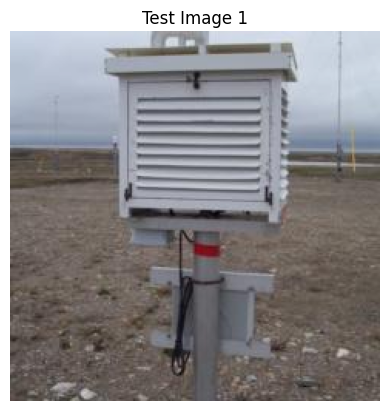

🔹 Test Image 2:
  🔷Real Caption: Gymnammodytes cicerelus Gymnammodytes cicerelus Picture of
Gymnammodytes cicerelus Gymnammodytes cicerelus also known as
Mediterranean sand eel sonso in Catalan and barrinaire or enfú in
Menorca is a fish in the family Ammodytidae It is the only species of
this family in the Mediterranean Sea It is a species from the family
Ammodytidae the sandlances or sandeels It is found over sandy or
gravelly substrates in the eastcentral Atlantic from Portugal to
Senegal including the Canary Islands and the Cape Verde Islands and
into the Mediterranean Sea and eastwards into the Black Sea Its
maximum size is 17 cm It is
  🔶Generated Caption: history of the united states army air force and the united states army
of the united states army of the united states army of the united
states army of the united states army of the united states army of the
united states army of the united states army of the united states army
of the united states army of the united states arm

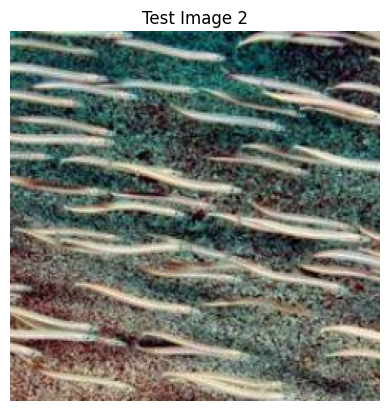

🔹 Test Image 3:
  🔷Real Caption: Aztec codices Aztec codices History of Tlaxcala Hernán Cortés and
Malinche meet Moctezuma II Tenochtitlan Entrance of Her Cortes
November 8 1519 From the Lienzo de Tlaxcala created by the Tlaxcalans
to remind the Spanish of their loyalty to Castile and the importance
of Tlaxcala during the Conquest The text mixes styles and includes
anachronisms such as the Europeanstyle chairs in this image Original
ca 1550 AD This facsimile published c 1890 Español Tenochtitlan Tierra
del nopal Entrada de Her Cortes la cual se verifico el 8 de Noviembre
de 1519 English Tenochtitlan Entrance of Her Cortes Cortez and La
  🔶Generated Caption: history of the united states army of the united states army of the
united states army of the united states army of the united states army
of the united states army of the united states army of the united
states army of the united states army of the united states army of the
united states army of the united states army of the united 

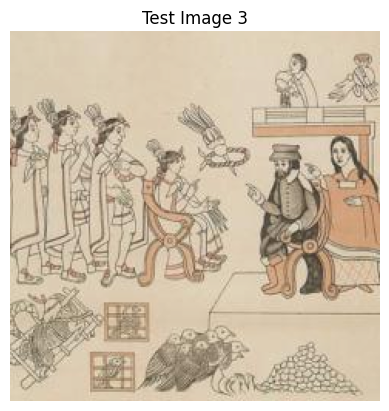


🎯 BLEU Score (for 3 images): 0.1624


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_caption(encoder, decoder, image_tensor, tokenizer, max_len=100):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoder_out = encoder(image_tensor.unsqueeze(0).to(device))
        h, c = decoder.init_hidden_state(encoder_out)

        caption = [tokenizer.cls_token_id]
        word_input = torch.tensor([caption[-1]]).to(device)

        for _ in range(max_len):
            word_embed = decoder.embedding(word_input) # Removed .squeeze(0)
            context, _ = decoder.attention(encoder_out, h)
            lstm_input = torch.cat([word_embed, context], dim=1)
            h, c = decoder.decode_step(lstm_input, (h, c))
            output = decoder.fc(h)
            next_token = output.argmax(1).item()
            caption.append(next_token)
            if next_token == tokenizer.sep_token_id:
                break
            word_input = torch.tensor([next_token]).to(device)

        return tokenizer.decode(caption, skip_special_tokens=True)


def evaluate_bleu(encoder, decoder, test_loader, tokenizer, num_examples_to_show=3):
    references, hypotheses = [], []

    print(f"\n🧪 Generating captions for {num_examples_to_show} test images...\n")

    for idx, batch in enumerate(test_loader):
        image = batch['image'][0].to(device) # Ensure image is on the correct device
        real_caption = batch['caption'][0]
        generated_caption = generate_caption(encoder, decoder, image, tokenizer)

        references.append([real_caption.lower().split()])
        hypotheses.append(generated_caption.lower().split())

        print(f"🔹 Test Image {idx+1}:")
        print(f"  🔷Real Caption: {textwrap.fill(real_caption, 70)}")
        print(f"  🔶Generated Caption: {textwrap.fill(generated_caption, 70)}\n")

        plt.figure()
        image_np = image.cpu().permute(1, 2, 0).numpy() # Move to CPU for plotting
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
        plt.imshow(image_np)
        plt.axis('off')
        plt.title(f"Test Image {idx+1}")
        plt.show()

        if idx == num_examples_to_show - 1:
            break

    score = corpus_bleu(references, hypotheses)
    
    # Saving model-3 BELU Score
    bleu_dict = {"Model-3": score}
    with open("model3_bleu.json", "w") as f:
        json.dump(bleu_dict, f)
    
    print(f"\n🎯 BLEU Score (for {num_examples_to_show} images): {score:.4f}")

# Ensure your encoder and decoder are in evaluation mode
encoder.eval()
decoder.eval()

# Evaluation
evaluate_bleu(encoder, decoder, test_loader, tokenizer, num_examples_to_show=3)

# Model 4: Transformer Decoder with Pretrained CNN

100%|██████████| 1129/1129 [01:10<00:00, 16.03it/s]


Epoch 1 | Train Loss: 7.8881, Train Acc: 0.0869 | Val Loss: 7.5542, Val Acc: 0.1067


100%|██████████| 1129/1129 [01:09<00:00, 16.28it/s]


Epoch 2 | Train Loss: 7.1076, Train Acc: 0.1210 | Val Loss: 7.2496, Val Acc: 0.1243


100%|██████████| 1129/1129 [01:08<00:00, 16.41it/s]


Epoch 3 | Train Loss: 6.6054, Train Acc: 0.1417 | Val Loss: 7.0500, Val Acc: 0.1313


100%|██████████| 1129/1129 [01:08<00:00, 16.42it/s]


Epoch 4 | Train Loss: 6.1608, Train Acc: 0.1596 | Val Loss: 6.9177, Val Acc: 0.1386


100%|██████████| 1129/1129 [01:08<00:00, 16.40it/s]


Epoch 5 | Train Loss: 5.7413, Train Acc: 0.1801 | Val Loss: 6.8416, Val Acc: 0.1442


100%|██████████| 1129/1129 [01:08<00:00, 16.41it/s]


Epoch 6 | Train Loss: 5.3372, Train Acc: 0.2029 | Val Loss: 6.8105, Val Acc: 0.1488


100%|██████████| 1129/1129 [01:08<00:00, 16.41it/s]


Epoch 7 | Train Loss: 4.9536, Train Acc: 0.2294 | Val Loss: 6.7915, Val Acc: 0.1559


100%|██████████| 1129/1129 [01:08<00:00, 16.41it/s]


Epoch 8 | Train Loss: 4.5857, Train Acc: 0.2593 | Val Loss: 6.8201, Val Acc: 0.1575


100%|██████████| 1129/1129 [01:08<00:00, 16.42it/s]


Epoch 9 | Train Loss: 4.2354, Train Acc: 0.2905 | Val Loss: 6.8493, Val Acc: 0.1616


100%|██████████| 1129/1129 [01:08<00:00, 16.41it/s]


Epoch 10 | Train Loss: 3.9088, Train Acc: 0.3223 | Val Loss: 6.9112, Val Acc: 0.1620


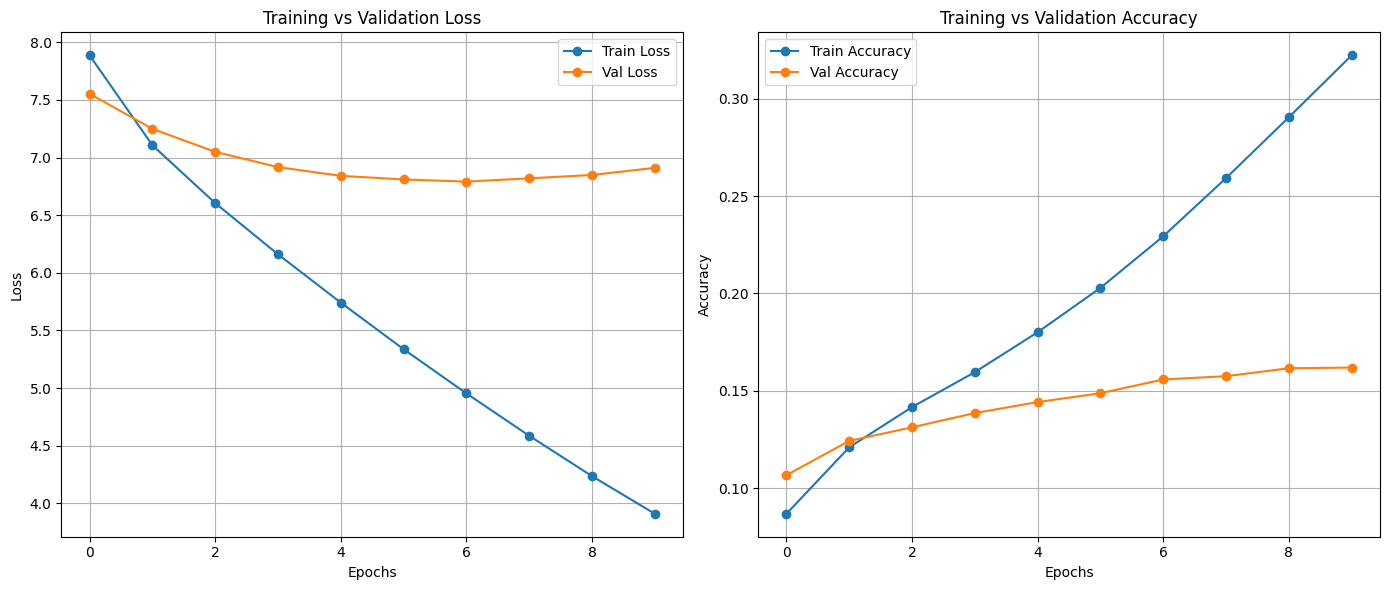

In [16]:
class CNNEncoder(nn.Module):
    def __init__(self, cnn_model='resnet50'):
        super(CNNEncoder, self).__init__()
        base_model = models.resnet50(pretrained=True)
        modules = list(base_model.children())[:-1]  # Remove the classification layer
        self.cnn = nn.Sequential(*modules)
        self.fc = nn.Linear(2048, 512)  # Adjust for resnet50's output

    def forward(self, images):
        with torch.no_grad():
            features = self.cnn(images) # Shape: [batch_size, 2048, 1, 1]
            features = features.squeeze(-1).squeeze(-1) # Shape: [batch_size, 2048]
        features = self.fc(features) # Shape: [batch_size, 512]
        return features  # shape: [batch_size, 512]

class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=3, dropout=0.1):
        super(TransformerDecoderModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Parameter(torch.rand(1, 100, d_model))  # Max caption length = 100

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, img_features, tgt_ids, tgt_mask=None):
        tgt_emb = self.embedding(tgt_ids) + self.pos_encoder[:, :tgt_ids.size(1), :]
        tgt_emb = self.dropout(tgt_emb)

        img_features = img_features.unsqueeze(1)  # [B, 1, d_model]
        img_features = img_features.permute(1, 0, 2)  # [1, B, d_model]

        tgt_emb = tgt_emb.permute(1, 0, 2)  # [T, B, d_model]

        output = self.transformer_decoder(tgt_emb, img_features, tgt_mask=tgt_mask)
        output = output.permute(1, 0, 2)  # [B, T, d_model]
        return self.fc_out(output)

vocab_size = tokenizer.vocab_size  # tokenizer from Hugging Face
encoder = CNNEncoder(cnn_model='resnet50')
decoder = TransformerDecoderModel(vocab_size=vocab_size)

def train_model(encoder, decoder, train_loader, val_loader, tokenizer, num_epochs=10, lr=1e-4, device='cuda'):
    encoder.to(device)
    decoder.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
    }

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        total_loss, total_correct, total_tokens = 0, 0, 0

        for batch in tqdm(train_loader):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)

            tgt_input = input_ids[:, :-1]
            tgt_output = input_ids[:, 1:]

            img_features = encoder(images)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            outputs = decoder(img_features, tgt_input, tgt_mask)

            loss = criterion(outputs.view(-1, outputs.size(-1)), tgt_output.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = outputs.argmax(dim=-1)
            mask = (tgt_output != tokenizer.pad_token_id)
            correct = (preds == tgt_output) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()

        train_accuracy = total_correct / total_tokens
        avg_train_loss = total_loss / len(train_loader)

        val_loss, val_accuracy = evaluate_model(encoder, decoder, val_loader, tokenizer, criterion, device)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return history

def evaluate_model(encoder, decoder, val_loader, tokenizer, criterion, device='cuda'):
    encoder.eval()
    decoder.eval()
    total_loss, total_correct, total_tokens = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)

            tgt_input = input_ids[:, :-1]
            tgt_output = input_ids[:, 1:]

            img_features = encoder(images)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            outputs = decoder(img_features, tgt_input, tgt_mask)

            loss = criterion(outputs.view(-1, outputs.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

            preds = outputs.argmax(dim=-1)
            mask = (tgt_output != tokenizer.pad_token_id)
            correct = (preds == tgt_output) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()

    val_accuracy = total_correct / total_tokens
    return total_loss / len(val_loader), val_accuracy

def plot_history(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # saving in result history
    history_model4 = {
        "train_loss": history['train_loss'],
        "val_loss": history['val_loss'],
        "train_acc": history['train_accuracy'],
        "val_acc": history['val_accuracy']
    }
    with open("model4_history.pkl", "wb") as f:
        pickle.dump(history_model4, f)

history = train_model(
    encoder=encoder,
    decoder=decoder,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    num_epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

plot_history(history)

## Printing Model Architecture

In [17]:
print("➡️ Encoder Architecture:")
print(encoder)

print("\n➡️ Decoder Architecture:")
print(decoder)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

encoder_params = count_parameters(encoder)
decoder_params = count_parameters(decoder)
total_params = encoder_params + decoder_params

print(f"\n⚙️ Number of trainable parameters in Encoder: {encoder_params:,}")
print(f"⚙️ Number of trainable parameters in Decoder: {decoder_params:,}")
print(f"📊 Total number of trainable parameters in the Model: {total_params:,}")

➡️ Encoder Architecture:
CNNEncoder(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

## Test data results and BLEU score


🖼️ Image 1


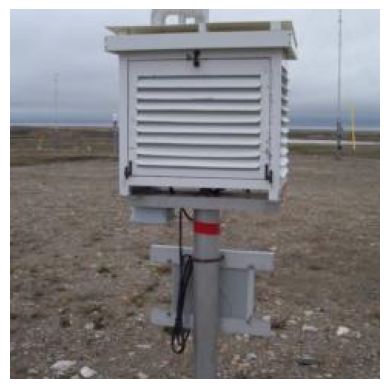

✅ Real Caption: stevenson screen stevenson screen exterior of a stevenson screen a stevenson screen or instrument shelter is a shelter or an enclosure to meteorological instruments against precipitation and direct heat radiation from outside sources while still allowing air to circulate freely around them it forms part of a standard weather station and holds instruments that may include thermometers a hygrometer a psychrometer a dewcell a barometer and a thermograph stevenson screens may also be known as a cotton region shelter an instrument
🤖 Predicted Caption: the prehistoric life of the prehistoric life of the prehistoric life of the united states army of the united states
🔵 BLEU Score (Image 1): 0.0266

🖼️ Image 2


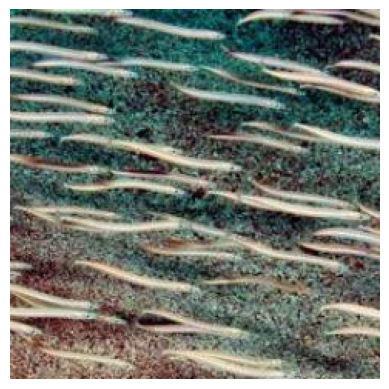

✅ Real Caption: gymnammodytes cicerelus gymnammodytes cicerelus picture of gymnammodytes cicerelus gymnammodytes cicerelus also known as mediterranean sand eel sonso in catalan and barrinaire or enfu in menorca is a fish in the family ammodytidae it is the only species of this family in the mediterranean sea it is a species from the family ammodytidae the sandlances or sand
🤖 Predicted Caption: the prehistoric life of california selected cenozoic taxa of california the prehistoric life of california ceno
🔵 BLEU Score (Image 2): 0.0580

🖼️ Image 3


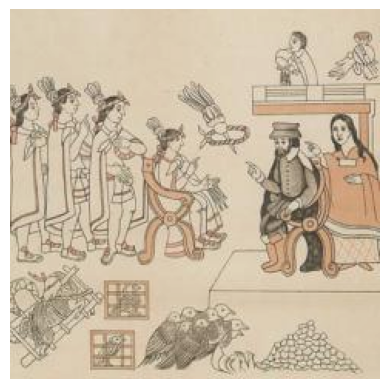

✅ Real Caption: aztec codices aztec codices history of tlaxcala hernan cortes and malinche meet moctezuma ii tenochtitlan entrance of her cortes november 8 1519 from the lienzo de tlaxcala created by the tlaxcalans to remind the spanish of their loyalty to castile and the importance of tlaxcala during the conquest the text mixes styles and includes anachronisms such as the europeanstyle chairs in this image original ca 1550 ad this fa
🤖 Predicted Caption: history of the united states history of the united states history of the united states 1789 the united states 1789
🔵 BLEU Score (Image 3): 0.0329

Overall BLEU Score (first 3 samples): 0.0392


In [18]:
from nltk.translate.bleu_score import sentence_bleu
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show_image(tensor):
    # Reverse the normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * std + mean)  # Unnormalize
    image = np.clip(image, 0, 1)   # Clip values to the valid range [0, 1]
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')

def greedy_decode(encoder, decoder, image_tensor, tokenizer, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        img_feature = encoder(image_tensor)
        caption_ids = [tokenizer.cls_token_id]

        for _ in range(max_length):
            input_tensor = torch.tensor(caption_ids).unsqueeze(0).to(device)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(input_tensor.size(1)).to(device)
            output = decoder(img_feature, input_tensor, tgt_mask)
            next_token = output.argmax(-1)[:, -1].item()
            if next_token == tokenizer.sep_token_id:
                break
            caption_ids.append(next_token)

        return tokenizer.decode(caption_ids[1:], skip_special_tokens=True)

individual_bleu_scores = []

for i in range(3):
    sample = test_dataset[i]
    image_tensor = sample['image']
    real_caption = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    predicted_caption = greedy_decode(encoder, decoder, image_tensor, tokenizer)

    print(f"\n🖼️ Image {i+1}")
    show_image(image_tensor)
    plt.show()
    print(f"✅ Real Caption: {real_caption}")
    print(f"🤖 Predicted Caption: {predicted_caption}")

    reference = [real_caption.split()]  # sentence_bleu expects a list of reference token lists
    hypothesis = predicted_caption.split()

    bleu_score = sentence_bleu(reference, hypothesis)
    print(f"🔵 BLEU Score (Image {i+1}): {bleu_score:.4f}")
    individual_bleu_scores.append(bleu_score)

if individual_bleu_scores:
    avg_bleu_score = sum(individual_bleu_scores) / len(individual_bleu_scores)
    print(f"\nOverall BLEU Score (first 3 samples): {avg_bleu_score:.4f}")

    # Saving model-4 BELU Score (average of the first 3)
    bleu_dict = {"Model-4": avg_bleu_score}
    with open("model4_bleu.json", "w") as f:
        json.dump(bleu_dict, f)
else:
    print("\nNo BLEU scores calculated.")

# Model-5: Setup and train CNN + BERT Fusion


➡️ Setting up CNN+BERT Fusion Model Architecture...

➡️ Initializing the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-20-47da3e41137c>:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training


🖥️ Using device: cuda

➡️ Starting training for 5 epochs...



Epoch 1/5:   0%|          | 0/1129 [00:00<?, ?it/s]<ipython-input-20-47da3e41137c>:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 1129/1129 [01:09<00:00, 16.27it/s, loss=6.5385, acc=0.1919]


💯 Validating epoch 1...


Validating: 100%|██████████| 24/24 [00:00<00:00, 24.22it/s]


Epoch 1/5 - Train Loss: 7.6539, Train Acc: 0.1090, Val Loss: 7.2384, Val Acc: 0.1253
✅ Saved new best model with validation loss: 7.2384


Epoch 2/5: 100%|██████████| 1129/1129 [01:09<00:00, 16.30it/s, loss=6.3038, acc=0.1717]


💯 Validating epoch 2...


Validating: 100%|██████████| 24/24 [00:00<00:00, 24.30it/s]


Epoch 2/5 - Train Loss: 6.5039, Train Acc: 0.1579, Val Loss: 6.8594, Val Acc: 0.1498
✅ Saved new best model with validation loss: 6.8594


Epoch 3/5: 100%|██████████| 1129/1129 [01:09<00:00, 16.25it/s, loss=5.9251, acc=0.1515]


💯 Validating epoch 3...


Validating: 100%|██████████| 24/24 [00:00<00:00, 24.22it/s]


Epoch 3/5 - Train Loss: 5.6747, Train Acc: 0.2001, Val Loss: 6.6061, Val Acc: 0.1653
✅ Saved new best model with validation loss: 6.6061


Epoch 4/5: 100%|██████████| 1129/1129 [01:09<00:00, 16.31it/s, loss=4.6898, acc=0.2727]


💯 Validating epoch 4...


Validating: 100%|██████████| 24/24 [00:00<00:00, 24.14it/s]


Epoch 4/5 - Train Loss: 4.9099, Train Acc: 0.2491, Val Loss: 6.4604, Val Acc: 0.1781
✅ Saved new best model with validation loss: 6.4604


Epoch 5/5: 100%|██████████| 1129/1129 [01:09<00:00, 16.32it/s, loss=4.6695, acc=0.2222]


💯 Validating epoch 5...


Validating: 100%|██████████| 24/24 [00:01<00:00, 23.74it/s]


Epoch 5/5 - Train Loss: 4.1952, Train Acc: 0.3079, Val Loss: 6.3979, Val Acc: 0.1824
✅ Saved new best model with validation loss: 6.3979

✅ Training completed!

➡️ Plotting Training Metrics...


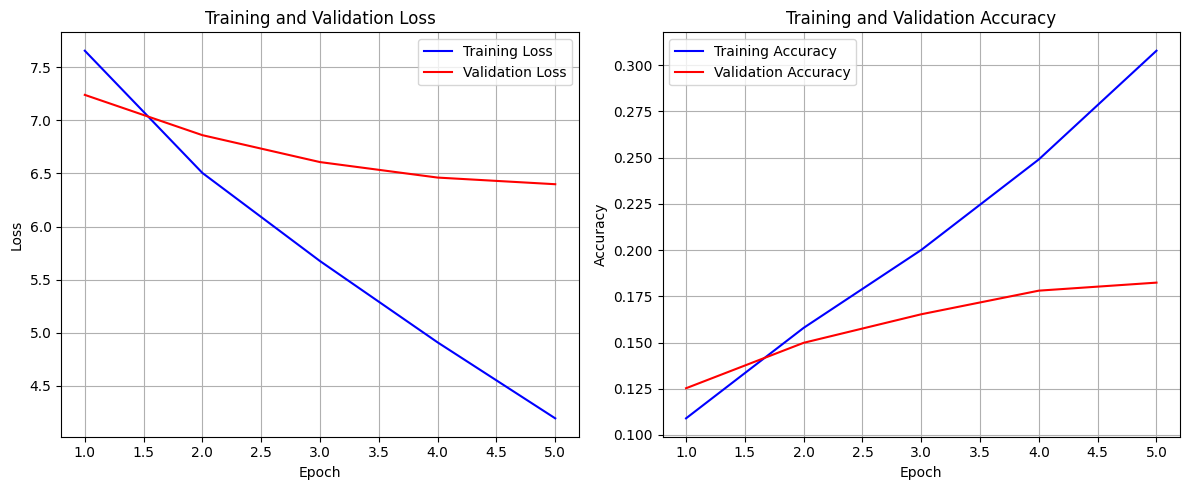


➡️ Loading best model for caption generation...


<ipython-input-20-47da3e41137c>:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))


➡️ Generating captions for test images...


<ipython-input-20-47da3e41137c>:319: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig('caption_generation_samples.png')
<ipython-input-20-47da3e41137c>:319: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.savefig('caption_generation_samples.png')
<ipython-input-20-47da3e41137c>:319: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from current font.
  plt.savefig('caption_generation_samples.png')
<ipython-input-20-47da3e41137c>:319: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.savefig('caption_generation_samples.png')
<ipython-input-20-47da3e41137c>:319: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from current font.
  plt.savefig('caption_generation_samples.png')
<ipython-input-20-47da3e41137c>:319: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from current font.
  plt.savefig('caption_gener

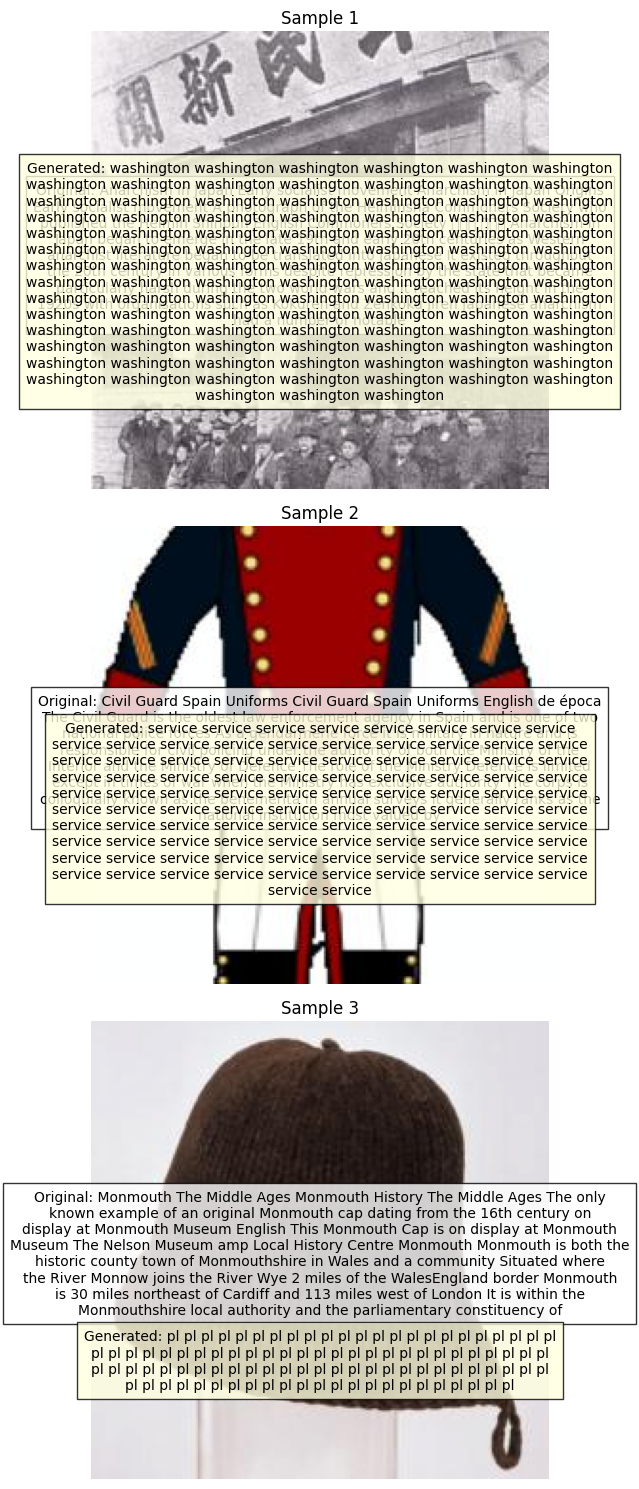


➡️ Calculating BLEU scores on test set...


Calculating BLEU:  53%|█████▎    | 50/95 [00:17<00:16,  2.79it/s]



📊 BLEU Scores:
BLEU-1: 1.98%
BLEU-2: 14.07%
BLEU-3: 27.41%
BLEU-4: 37.51%


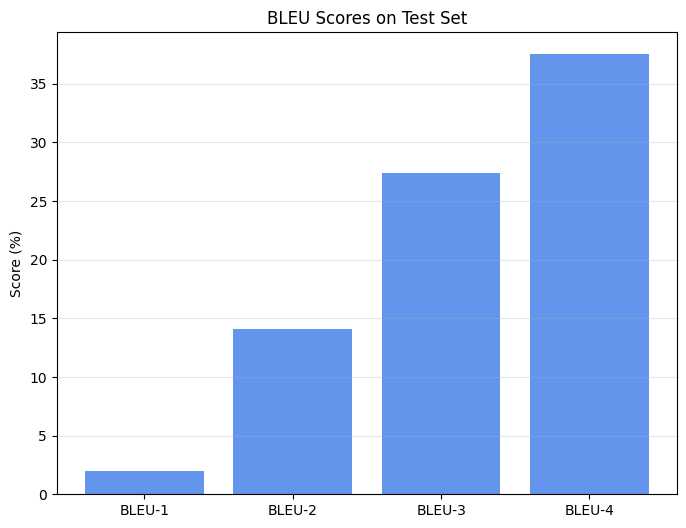


✅ Caption generation and evaluation completed!

➡️ Model Summary:
🔢 Total Parameters: 94,049,914
🔄 Trainable Parameters: 94,049,914
🧠 Model Architecture: CNN (ResNet50) + Transformer Encoder
📚 Vocabulary Size: 30,522
📊 Best Validation Loss: 6.3979
📈 Final Training Accuracy: 0.3079
📊 Final Validation Accuracy: 0.1824
🏆 Best BLEU-4 Score: 37.51%


In [20]:
# --- MODEL ARCHITECTURE ---
print("\n➡️ Setting up CNN+BERT Fusion Model Architecture...\n")

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, hidden_dim=512, num_heads=8, num_layers=4):
        super(ImageCaptioningModel, self).__init__()
        
        # Image encoder (CNN)
        self.image_encoder = models.resnet50(pretrained=True)
        # Remove the final classification layer
        self.image_encoder = nn.Sequential(*list(self.image_encoder.children())[:-1])
        
        # Project image features to embedding dimension
        self.img_projection = nn.Linear(2048, embed_dim)
        
        # Text encoder-decoder (Transformer)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Word embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Output projection
        self.output_projection = nn.Linear(embed_dim, vocab_size)
        
        # Other parameters
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        
    def forward(self, images, input_ids, attention_mask=None):
        batch_size = images.size(0)
        
        # Process images through CNN
        with torch.no_grad():  # Freeze ResNet weights
            image_features = self.image_encoder(images)  # [batch_size, 2048, 1, 1]
        
        image_features = image_features.view(batch_size, -1)  # [batch_size, 2048]
        image_embeddings = self.img_projection(image_features)  # [batch_size, embed_dim]
        
        # Process captions
        text_embeddings = self.embedding(input_ids)  # [batch_size, seq_len, embed_dim]
        
        # Combine image and text embeddings
        # Add image embedding as first token
        image_embeddings = image_embeddings.unsqueeze(1)  # [batch_size, 1, embed_dim]
        combined_embeddings = torch.cat([image_embeddings, text_embeddings], dim=1)  # [batch_size, seq_len+1, embed_dim]
        
        # Pass through transformer encoder
        combined_embeddings = combined_embeddings.permute(1, 0, 2)  # [seq_len+1, batch_size, embed_dim]
        transformer_output = self.transformer_encoder(combined_embeddings)  # [seq_len+1, batch_size, embed_dim]
        transformer_output = transformer_output.permute(1, 0, 2)  # [batch_size, seq_len+1, embed_dim]
        
        # Project output to vocabulary
        logits = self.output_projection(transformer_output)  # [batch_size, seq_len+1, vocab_size]
        
        # Remove the image token prediction
        logits = logits[:, 1:, :]  # [batch_size, seq_len, vocab_size]
        
        return logits
    
    def generate_caption(self, image, tokenizer, max_length=100):
        """Generate a caption for a given image"""
        device = next(self.parameters()).device
        image = image.to(device)
        
        with torch.no_grad():
            # Process image through CNN
            image_features = self.image_encoder(image.unsqueeze(0))  # [1, 2048, 1, 1]
            image_features = image_features.view(1, -1)  # [1, 2048]
            image_embeddings = self.img_projection(image_features)  # [1, embed_dim]
            
            # Start with BOS token
            input_ids = torch.tensor([[tokenizer.cls_token_id]]).to(device)  # [1, 1]
            
            for _ in range(max_length):
                # Get embeddings for current sequence
                text_embeddings = self.embedding(input_ids)  # [1, current_len, embed_dim]
                
                # Combine with image embedding
                image_embeddings_expanded = image_embeddings.unsqueeze(1)  # [1, 1, embed_dim]
                combined_embeddings = torch.cat([image_embeddings_expanded, text_embeddings], dim=1)  # [1, current_len+1, embed_dim]
                
                # Pass through transformer
                combined_embeddings = combined_embeddings.permute(1, 0, 2)  # [current_len+1, 1, embed_dim]
                transformer_output = self.transformer_encoder(combined_embeddings)  # [current_len+1, 1, embed_dim]
                transformer_output = transformer_output.permute(1, 0, 2)  # [1, current_len+1, embed_dim]
                
                # Get logits
                logits = self.output_projection(transformer_output)  # [1, current_len+1, vocab_size]
                
                # Predict next token (from last position, excluding image token)
                next_token_logits = logits[0, -1, :]  # [vocab_size]
                next_token = torch.argmax(next_token_logits).unsqueeze(0).unsqueeze(0)  # [1, 1]
                
                # Append to input_ids
                input_ids = torch.cat([input_ids, next_token], dim=1)  # [1, current_len+1]
                
                # Stop if EOS token is predicted
                if next_token.item() == tokenizer.sep_token_id:
                    break
        
        # Decode caption
        caption_ids = input_ids[0].tolist()
        caption = tokenizer.decode(caption_ids, skip_special_tokens=True)
        
        return caption

# Initialize model
print("➡️ Initializing the model...")
vocab_size = tokenizer.vocab_size
model = ImageCaptioningModel(vocab_size)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scaler = GradScaler()  # For mixed precision training

# --- TRAINING LOOP ---
print("\n➡️ Starting training for 5 epochs...\n")

def calculate_accuracy(logits, target):
    """Calculate accuracy of predictions vs targets"""
    pred = torch.argmax(logits, dim=-1)
    valid = (target != tokenizer.pad_token_id)
    acc_per_sample = torch.sum((pred == target) & valid, dim=-1) / torch.sum(valid, dim=-1)
    accuracy = acc_per_sample.mean().item()
    return accuracy

def validate(model, dataloader, criterion, device):
    """Validate the model on the validation set"""
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass
            logits = model(images, input_ids[:, :-1])  # [batch_size, seq_len-1, vocab_size]
            
            # Calculate loss
            logits = logits.contiguous().view(-1, logits.size(-1))
            targets = input_ids[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            
            # Calculate accuracy
            logits = logits.view(input_ids.size(0), -1, logits.size(-1))
            accuracy = calculate_accuracy(logits, input_ids[:, 1:])
            
            val_loss += loss.item()
            val_acc += accuracy
            num_batches += 1
    
    return val_loss / num_batches, val_acc / num_batches

# Training metrics tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
NUM_EPOCHS = 5
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with autocast():
            logits = model(images, input_ids[:, :-1])  # Input: all but last token, predict from second token
            
            # Reshape for loss calculation
            logits = logits.contiguous().view(-1, logits.size(-1))
            targets = input_ids[:, 1:].contiguous().view(-1)  # Target: all but first token
            
            # Calculate loss
            loss = criterion(logits, targets)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Calculate accuracy
        with torch.no_grad():
            logits = logits.view(input_ids.size(0), -1, logits.size(-1))
            accuracy = calculate_accuracy(logits, input_ids[:, 1:])
        
        # Update metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{accuracy:.4f}"
        })
    
    # Epoch metrics
    avg_train_loss = epoch_loss / num_batches
    avg_train_acc = epoch_acc / num_batches
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # Validation
    print(f"💯 Validating epoch {epoch+1}...")
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✅ Saved new best model with validation loss: {val_loss:.4f}")

print("\n✅ Training completed!\n")

# --- PLOT METRICS ---
print("➡️ Plotting Training Metrics...")

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# --- CAPTION GENERATION ---
print("\n➡️ Loading best model for caption generation...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

print("➡️ Generating captions for test images...")
# Get 3 random samples from test set
test_samples_indices = random.sample(range(len(test_dataset)), 3)
test_samples = [test_dataset[i] for i in test_samples_indices]

# Generate captions
plt.figure(figsize=(15, 15))
generated_captions = []
reference_captions = []

for i, sample in enumerate(test_samples):
    image = sample['image'].to(device)
    original_caption = sample['caption']
    
    # Generate caption
    generated_caption = model.generate_caption(image, tokenizer)
    
    # Display image and captions
    plt.subplot(3, 1, i+1)
    img = image.cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Sample {i+1}")
    plt.axis('off')
    
    wrapped_original = textwrap.fill(f"Original: {original_caption}", width=80)
    wrapped_generated = textwrap.fill(f"Generated: {generated_caption}", width=80)
    
    plt.figtext(0.5, 0.78-i*0.33, wrapped_original, ha="center", fontsize=10, 
               bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    plt.figtext(0.5, 0.73-i*0.33, wrapped_generated, ha="center", fontsize=10,
               bbox={"facecolor":"lightyellow", "alpha":0.8, "pad":5})
    
    # Store for BLEU calculation
    generated_captions.append(generated_caption.split())
    reference_captions.append([original_caption.split()])

plt.tight_layout()
plt.savefig('caption_generation_samples.png')
plt.show()

# --- BLEU SCORE CALCULATION ---
print("\n➡️ Calculating BLEU scores on test set...")

def calculate_bleu_scores(model, dataloader, tokenizer, device, num_samples=None):
    model.eval()
    hypotheses = []
    references = []
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Calculating BLEU")):
            if num_samples and i >= num_samples:
                break
                
            image = batch['image'][0].to(device)  # Only one image per batch in test_loader
            caption = batch['caption'][0]
            
            # Generate caption
            generated_caption = model.generate_caption(image, tokenizer)
            
            # Prepare for BLEU calculation
            hypotheses.append(generated_caption.split())
            references.append([caption.split()])
    
    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    return {
        'BLEU-1': bleu1 * 100,
        'BLEU-2': bleu2 * 100,
        'BLEU-3': bleu3 * 100,
        'BLEU-4': bleu4 * 100
    }

# Calculate BLEU on a subset of test set for efficiency
bleu_scores = calculate_bleu_scores(model, test_loader, tokenizer, device, num_samples=50)

print("\n📊 BLEU Scores:")
for metric, score in bleu_scores.items():
    print(f"{metric}: {score:.2f}%")

# Plot BLEU Scores
plt.figure(figsize=(8, 6))
plt.bar(bleu_scores.keys(), bleu_scores.values(), color='cornflowerblue')
plt.title('BLEU Scores on Test Set')
plt.ylabel('Score (%)')
plt.grid(axis='y', alpha=0.3)
plt.savefig('bleu_scores.png')
plt.show()

print("\n✅ Caption generation and evaluation completed!")

# --- FINAL MODEL SUMMARY ---
print("\n➡️ Model Summary:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔢 Total Parameters: {total_params:,}")
print(f"🔄 Trainable Parameters: {trainable_params:,}")
print(f"🧠 Model Architecture: CNN (ResNet50) + Transformer Encoder")
print(f"📚 Vocabulary Size: {vocab_size:,}")
print(f"📊 Best Validation Loss: {best_val_loss:.4f}")
print(f"📈 Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"📊 Final Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"🏆 Best BLEU-4 Score: {bleu_scores['BLEU-4']:.2f}%")

## Saving history and BLEU score

In [21]:
# --- SAVE TRAINING HISTORY ---
print("\n➡️ Saving training history...")
history_model5 = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'epochs': NUM_EPOCHS
}

with open("model5_history.pkl", "wb") as f:
    pickle.dump(history_model5, f)
print("✅ Training history saved to model5_history.pkl")

# --- SAVE BLEU SCORES ---
print("\n➡️ Saving BLEU scores...")
bleu_dict = {"Model-5": bleu_scores}
with open("model5_bleu.json", "w") as f:
    json.dump(bleu_dict, f)
print("✅ BLEU scores saved to model5_bleu.json")


➡️ Saving training history...
✅ Training history saved to model5_history.pkl

➡️ Saving BLEU scores...
✅ BLEU scores saved to model5_bleu.json


# Accuracy-Loss comparison

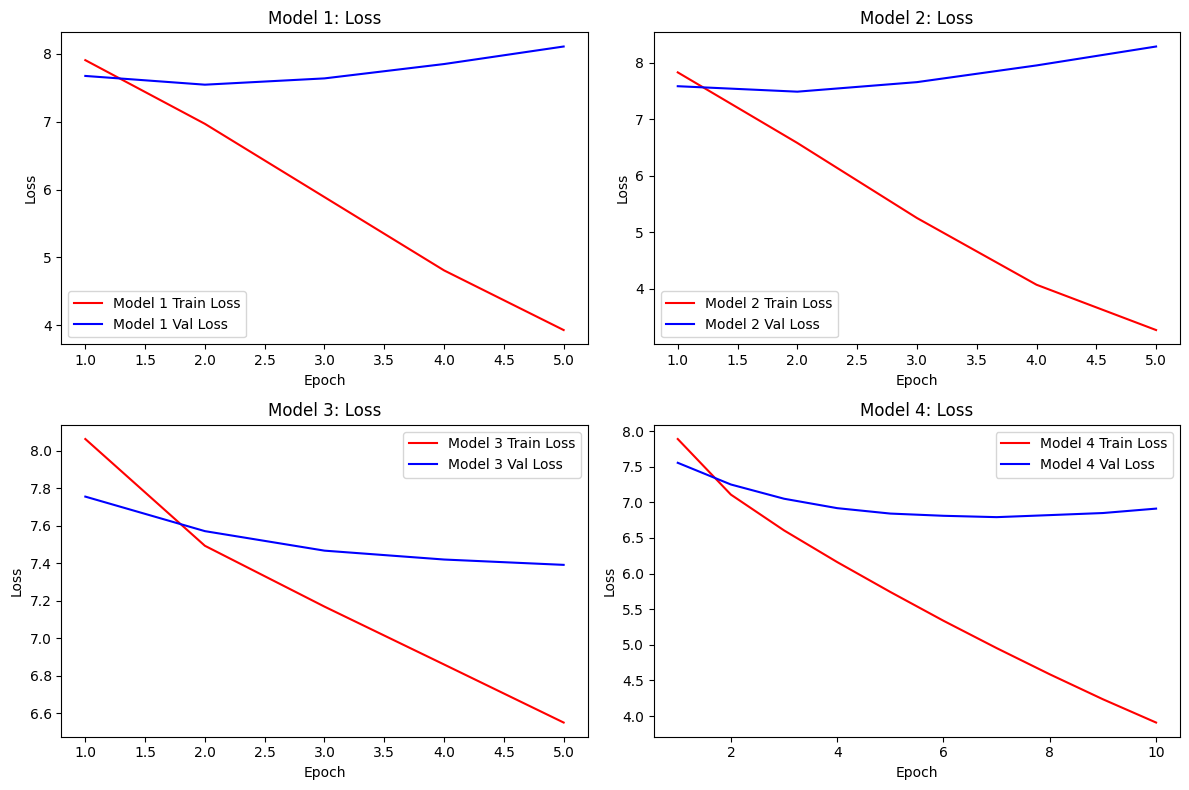

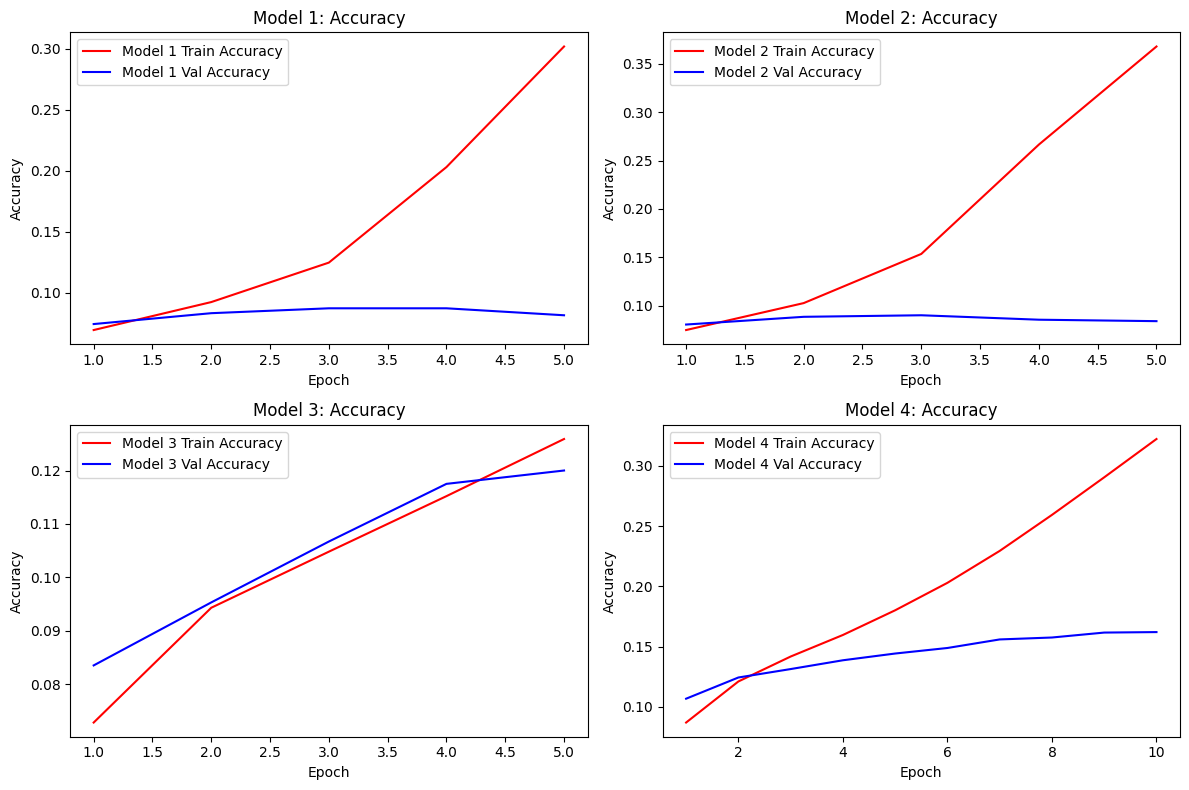

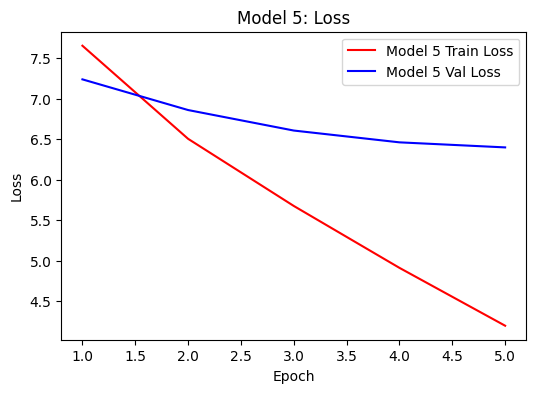

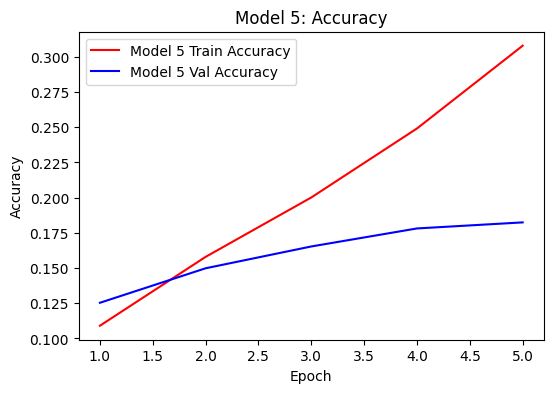

In [24]:
import matplotlib.pyplot as plt

# Data for Model 1 (CNN + LSTM)
model1_train_loss = [7.9071, 6.9687, 5.8889, 4.8088, 3.9298]
model1_val_loss = [7.6744, 7.5456, 7.6383, 7.8497, 8.1081]
model1_train_acc = [0.0696, 0.0925, 0.1248, 0.2030, 0.3017]
model1_val_acc = [0.0745, 0.0834, 0.0874, 0.0874, 0.0817]
model1_epochs = range(1, len(model1_train_loss) + 1)

# Data for Model 2 (CNN + GRU)
model2_train_loss = [7.8258, 6.5778, 5.2512, 4.0713, 3.2700]
model2_val_loss = [7.5812, 7.4847, 7.6534, 7.9487, 8.2832]
model2_train_acc = [0.0746, 0.1025, 0.1534, 0.2666, 0.3681]
model2_val_acc = [0.0803, 0.0883, 0.0899, 0.0853, 0.0838]
model2_epochs = range(1, len(model2_train_loss) + 1)  # Define model2_epochs

# Data for Model 3 (CNN + LSTM + Attention)
model3_train_loss = [8.0636, 7.4934, 7.1685, 6.8595, 6.5494]
model3_val_loss = [7.7560, 7.5716, 7.4674, 7.4200, 7.3915]
model3_train_acc = [0.0728, 0.0943, 0.1048, 0.1152, 0.1259]
model3_val_acc = [0.0835, 0.0953, 0.1067, 0.1175, 0.1200]
model3_epochs = range(1, len(model3_train_loss) + 1)  # Define model3_epochs

# Data for Model 4 (Transformer Decoder with Pretrained CNN)
model4_train_loss = [7.8881, 7.1076, 6.6054, 6.1608, 5.7413, 5.3372, 4.9536, 4.5857, 4.2354, 3.9088]
model4_val_loss = [7.5542, 7.2496, 7.0500, 6.9177, 6.8416, 6.8105, 6.7915, 6.8201, 6.8493, 6.9112]
model4_train_acc = [0.0869, 0.1210, 0.1417, 0.1596, 0.1801, 0.2029, 0.2294, 0.2593, 0.2905, 0.3223]
model4_val_acc = [0.1067, 0.1243, 0.1313, 0.1386, 0.1442, 0.1488, 0.1559, 0.1575, 0.1616, 0.1620]
model4_epochs = range(1, len(model4_train_loss) + 1)

# Data for Model 5 (CNN + BERT Fusion)
model5_train_loss = [7.6539, 6.5039, 5.6747, 4.9099, 4.1952]
model5_val_loss = [7.2384, 6.8594, 6.6061, 6.4604, 6.3979]
model5_train_acc = [0.1090, 0.1579, 0.2001, 0.2491, 0.3079]
model5_val_acc = [0.1253, 0.1498, 0.1653, 0.1781, 0.1824]
model5_epochs = range(1, len(model5_train_loss) + 1)  # Define model5_epochs

# Plotting Loss
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model1_epochs, model1_train_loss, 'r-', label='Model 1 Train Loss')
plt.plot(model1_epochs, model1_val_loss, 'b-', label='Model 1 Val Loss')
plt.title('Model 1: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(model2_epochs, model2_train_loss, 'r-', label='Model 2 Train Loss')
plt.plot(model2_epochs, model2_val_loss, 'b-', label='Model 2 Val Loss')
plt.title('Model 2: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(model3_epochs, model3_train_loss, 'r-', label='Model 3 Train Loss')
plt.plot(model3_epochs, model3_val_loss, 'b-', label='Model 3 Val Loss')
plt.title('Model 3: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(model4_epochs, model4_train_loss, 'r-', label='Model 4 Train Loss')
plt.plot(model4_epochs, model4_val_loss, 'b-', label='Model 4 Val Loss')
plt.title('Model 4: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model1_epochs, model1_train_acc, 'r-', label='Model 1 Train Accuracy')
plt.plot(model1_epochs, model1_val_acc, 'b-', label='Model 1 Val Accuracy')
plt.title('Model 1: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(model2_epochs, model2_train_acc, 'r-', label='Model 2 Train Accuracy')
plt.plot(model2_epochs, model2_val_acc, 'b-', label='Model 2 Val Accuracy')
plt.title('Model 2: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(model3_epochs, model3_train_acc, 'r-', label='Model 3 Train Accuracy')
plt.plot(model3_epochs, model3_val_acc, 'b-', label='Model 3 Val Accuracy')
plt.title('Model 3: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(model4_epochs, model4_train_acc, 'r-', label='Model 4 Train Accuracy')
plt.plot(model4_epochs, model4_val_acc, 'b-', label='Model 4 Val Accuracy')
plt.title('Model 4: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Separate plot for Model 5
plt.figure(figsize=(6, 4))
plt.plot(model5_epochs, model5_train_loss, 'r-', label='Model 5 Train Loss')
plt.plot(model5_epochs, model5_val_loss, 'b-', label='Model 5 Val Loss')
plt.title('Model 5: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(model5_epochs, model5_train_acc, 'r-', label='Model 5 Train Accuracy')
plt.plot(model5_epochs, model5_val_acc, 'b-', label='Model 5 Val Accuracy')
plt.title('Model 5: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# BLEU Score Comparison result

BELU Scores:
Model1: 0.0127
Model2: 0.0018
Model3: 0.1624
Model4: 0.0392
Model5_BLEU-1: 0.0198
Model5_BLEU-2: 0.1407
Model5_BLEU-3: 0.2741
Model5_BLEU-4: 0.3751

The best model based on the highest BLEU score is: Model5_BLEU-1


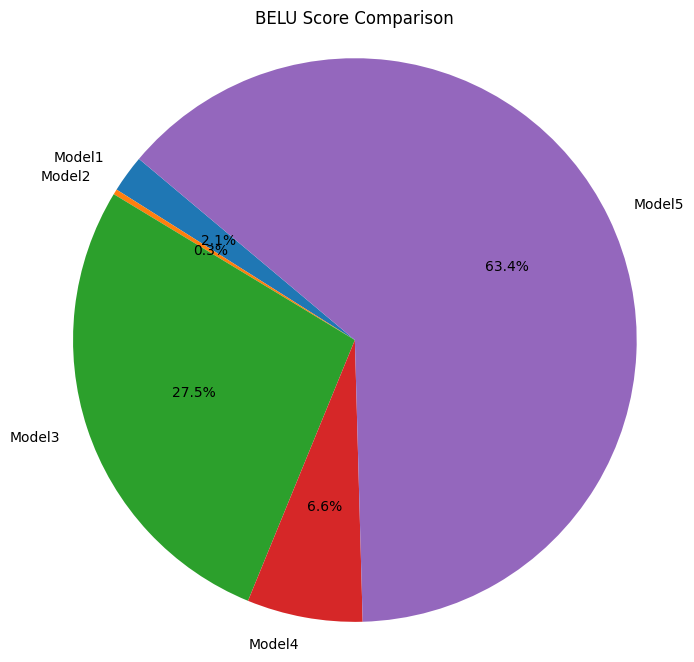

In [27]:
# BELU Score Comparison
bleu_scores = {
    "Model1": 0.0127,
    "Model2": 0.0018,
    "Model3": 0.1624,
    "Model4": 0.0392,
    "Model5_BLEU-1": 0.0198,  # Converting percentage to decimal
    "Model5_BLEU-2": 0.1407,
    "Model5_BLEU-3": 0.2741,
    "Model5_BLEU-4": 0.3751,
}

print("BELU Scores:")
for model, score in bleu_scores.items():
    print(f"{model}: {score:.4f}")

# Determine the best model based on the highest BLEU score
best_model = max(bleu_scores, key=lambda k: bleu_scores[k] if "Model5" not in k else bleu_scores["Model5_BLEU-4"])

print(f"\nThe best model based on the highest BLEU score is: {best_model}")

import matplotlib.pyplot as plt

# BELU Score Data (using BLEU-4 for Model 5)
model_names = ["Model1", "Model2", "Model3", "Model4", "Model5"]
scores = [
    bleu_scores["Model1"],
    bleu_scores["Model2"],
    bleu_scores["Model3"],
    bleu_scores["Model4"],
    bleu_scores["Model5_BLEU-4"],
]

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(scores, labels=model_names, autopct='%1.1f%%', startangle=140)
plt.title('BELU Score Comparison')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()